In [52]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime, timedelta, time
import learning_lidar.utils.global_settings as gs
import learning_lidar.utils.vis_utils as vis_utils
import pandas as pd
import learning_lidar.preprocessing.preprocessing_utils as prep_utils
import learning_lidar.preprocessing.preprocessing as prep
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
from learning_lidar.preprocessing.preprocessing_utils import  calc_r2_ds
from learning_lidar.generation.daily_signals_generations_utils import get_daily_bg
import learning_lidar.generation.generation_utils as gen_utils
from learning_lidar.dataseting.dataseting import calc_data_statistics
from learning_lidar.utils.proc_utils import  normalize
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler

from tqdm import tqdm
vis_utils.set_visualization_settings()

In [53]:
#os.chdir('/home/shubi/PycharmProjects/learning_lidar')

In [54]:
def daily_ds_histogram(dataset, profile_type='range_corr',
                       nbins=100, log_scale=False,
                       SAVE_FIG = False , dst_folder = os.path.join ( '..' , 'Figures' )
                       , format_fig = 'png'):
    date_datetime = prep_utils.get_daily_ds_date ( dataset )
    ds_profile = dataset.get(profile_type)
    df_stats = pd.DataFrame(columns=['wavelength [nm]', 'valid size %',
                                     'positive %', 'negative %','zeros %',
                                     'mean' , 'std'])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),sharey=True)
    ax = axes
    th = gs.eps
    for ind,(wavelength) in enumerate(dataset.Wavelength.values):
        sub_ds = ds_profile.sel(Wavelength = wavelength)
        mask_valid = (~pd.isna(sub_ds.values))
        valid_size = mask_valid.astype(int).sum()
        orig_size = sub_ds.values.size

        # positive values histogram
        pos_ds = sub_ds.where(sub_ds > th).where(sub_ds != np.nan)#.values
        pos_vals = pos_ds.values[~np.isnan(pos_ds.values)]
        pos_size = pos_vals.size

        # hist, bins =np.histogram(pos_vals , bins=nbins)
        # min_bin = bins[0] if bins[0]>0 else bins[0]+gs.eps
        # max_bin = bins[-1]
        # logbins = np.logspace(np.log10(min_bin),np.log10(max_bin),len(bins))
        # # was pos_vals
        # ax.hist(pos_vals, bins=logbins, label = f"$\lambda={wavelength}$",
        #            alpha=0.4)


        vals_ds = sub_ds.where(sub_ds != np.nan)
        vals = vals_ds.values[~np.isnan(vals_ds.values)]
        # hist, bins =np.histogram(vals , bins=nbins)
        # was pos_vals
        ax.hist(vals, bins=nbins, label = f"$\lambda={wavelength}$",
                   alpha=0.4)
        if log_scale:
            ax.set_xscale('symlog')

        #negative values histogram
        neg_ds = sub_ds.where(sub_ds < -th).where(sub_ds != np.nan )#.values
        neg_vals= neg_ds.values[~np.isnan(neg_ds.values)]
        neg_size = neg_vals.size


        # Zero values histogram
        zero_ds= sub_ds.where(sub_ds >= -th).where(sub_ds <=th).where(sub_ds != np.nan )
        zero_vals= zero_ds.values[~np.isnan(zero_ds.values)]
        zero_size = zero_vals.size

        df_stats.loc[ind] = [wavelength,
                            100.0*valid_size/orig_size,
                            100.0*pos_size/orig_size ,
                            100.0*neg_size/orig_size ,
                            100.0*zero_size/orig_size,
                            sub_ds.mean().values,
                            sub_ds.std().values]
        # TODO : take care of representation after the digit values

    ax.legend()
    min_val, max_val = float(ds_profile.min().values),float(ds_profile.max().values)
    ax.set_xlim([min_val,max_val+0.1*(max_val-min_val)])
    ax.set_ylabel('counts')
    ax.tick_params(axis='both', which='major')

    xlabels = f"{ds_profile.long_name} [{ds_profile.units}]"
    ax.set_xlabel(xlabels, horizontalalignment='center')
    axes.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
    stitle = f"Histogram of {ds_profile.info.lower()} " \
             f"\n {dataset.attrs['location']} {date_datetime.strftime('%Y-%m-%d')}"
    fig.suptitle(stitle)

    plt.tight_layout()
    plt.show()

    if SAVE_FIG :
        fname = f"{date_datetime.strftime ( '%Y-%m-%d' )}_{dataset.attrs ['location']}_{profile_type}_" \
                f"source_{dataset.attrs['source_type']}_histogram.{format_fig}"
        if not os.path.exists ( dst_folder ) :
            try :
                os.makedirs ( dst_folder , exist_ok = True )
                print (f"Creating folder: {dst_folder}") # logger.debug ( f"Creating folder: {dst_folder}" )
            except Exception :
                raise OSError ( f"Failed to create folder: {dst_folder}" )
        fpath = os.path.join ( dst_folder , fname )
        fig.savefig(fpath,bbox_inches='tight', format = format_fig)
        print(f"Figure saved at {fpath}") # logger.debug ( f"Figure saved at {fpath}" )
    return fig,axes,df_stats

In [55]:
#station_name = 'haifa_shubi_external'
station_name = 'haifa'
station = gs.Station(station_name)
wavelengths = gs.LAMBDA_nm().get_elastic()
dates = [datetime(2017,9,1), datetime(2017,9,2),datetime(2017,10,2),datetime(2017,10,15)]
dt_day = dates[0]
r2_da = calc_r2_ds(station, dt_day)
main_folder = os.path.dirname(os.path.abspath(os.path.curdir))
data_folder = os.path.join(os.path.dirname(os.path.abspath(os.path.curdir)), 'data')
times = [dt_day+ timedelta(hours=9),
         dt_day+ timedelta(hours=12),
         dt_day+ timedelta(hours=15),
         dt_day+ timedelta(hours=18)]

# 1. Optical Density signal


# 2. Background signal
# TODO: test transformers on bg_ds.bg and bg_r2

In [56]:
p_bg = get_daily_bg(station, dt_day)  # daily background: p_bg
# Expand p_bg to coordinates : 'Wavelength','Height', 'Time
bg_ds = p_bg.broadcast_like(r2_da).to_dataset()
bg_ds['date'] = dt_day
bg_ds.attrs['location'] = station.location

# vis_utils.plot_daily_profile(bg_ds.bg, figsize=(21,7))

## BG

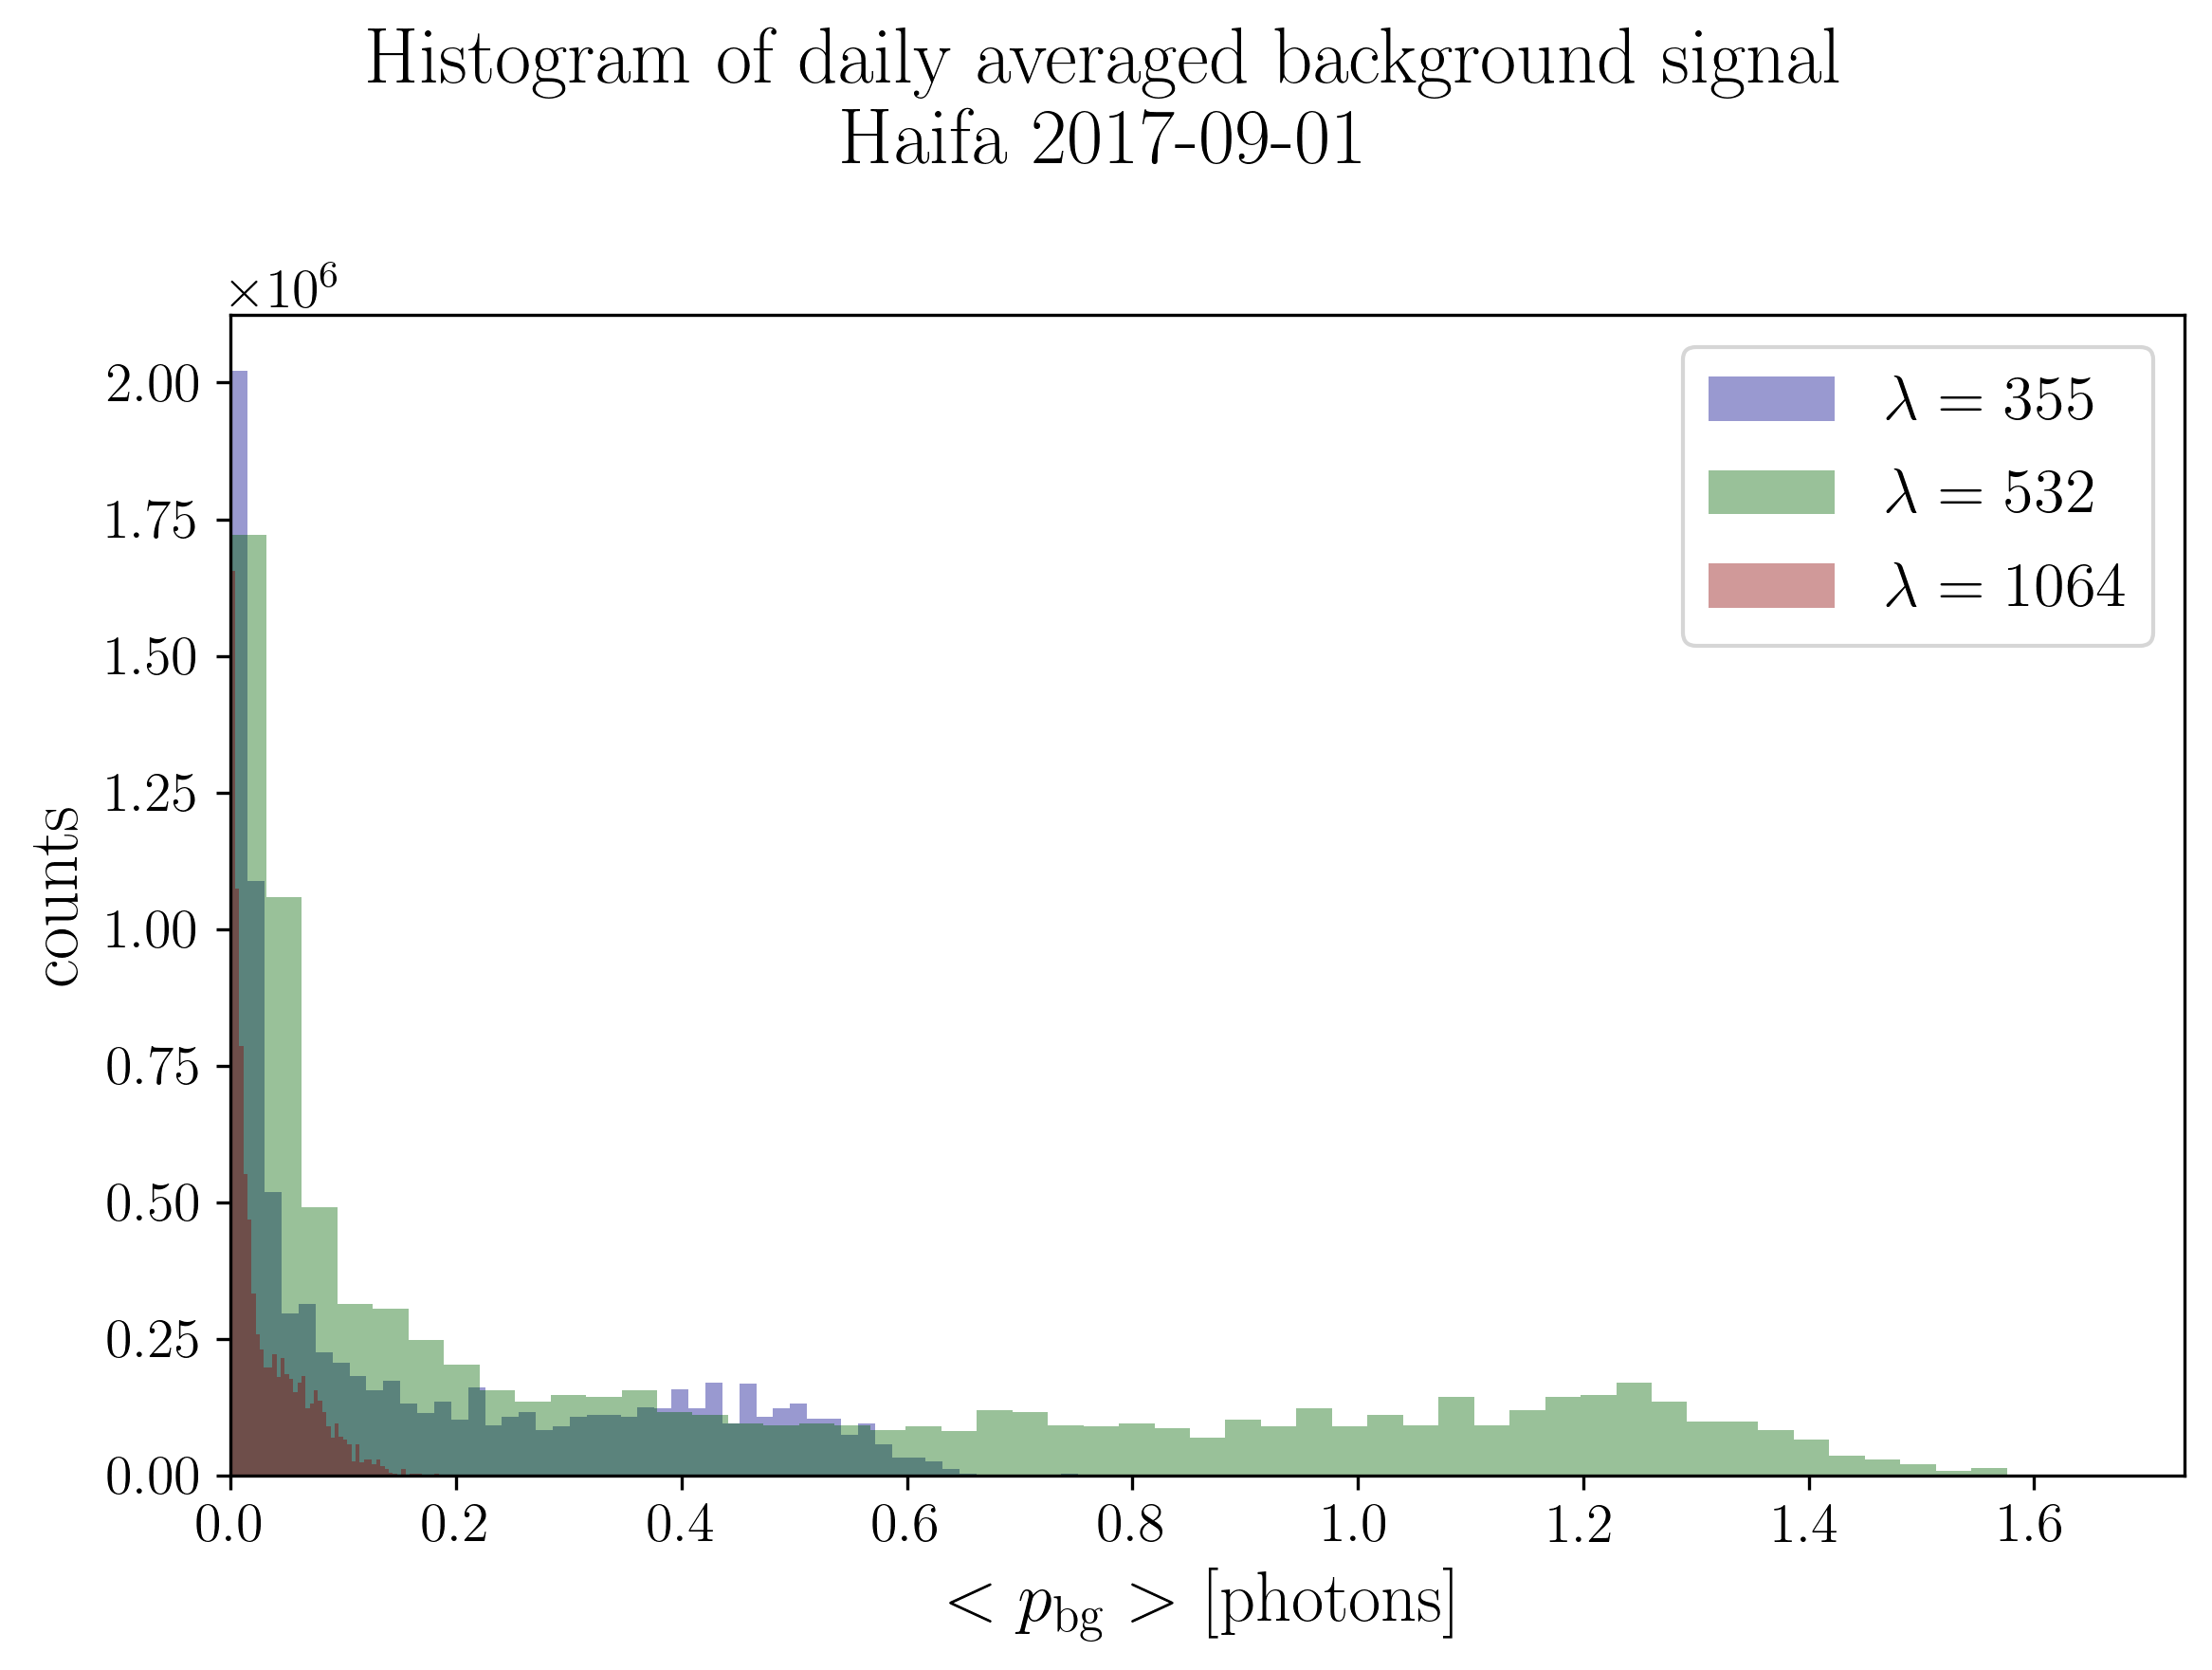

wavelength [nm]  valid size %  positive %  negative %   zeros %  \
0             355         100.0   95.451389         0.0  4.548611   
1             532         100.0   96.111111         0.0  3.888889   
2            1064         100.0   92.500000         0.0  7.500000   

          mean         std  
0    0.1710548  0.18464139  
1   0.44045407  0.46370745  
2  0.030882165  0.03291483

In [57]:
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg',nbins=50)
bg_stats


## BG Quantile

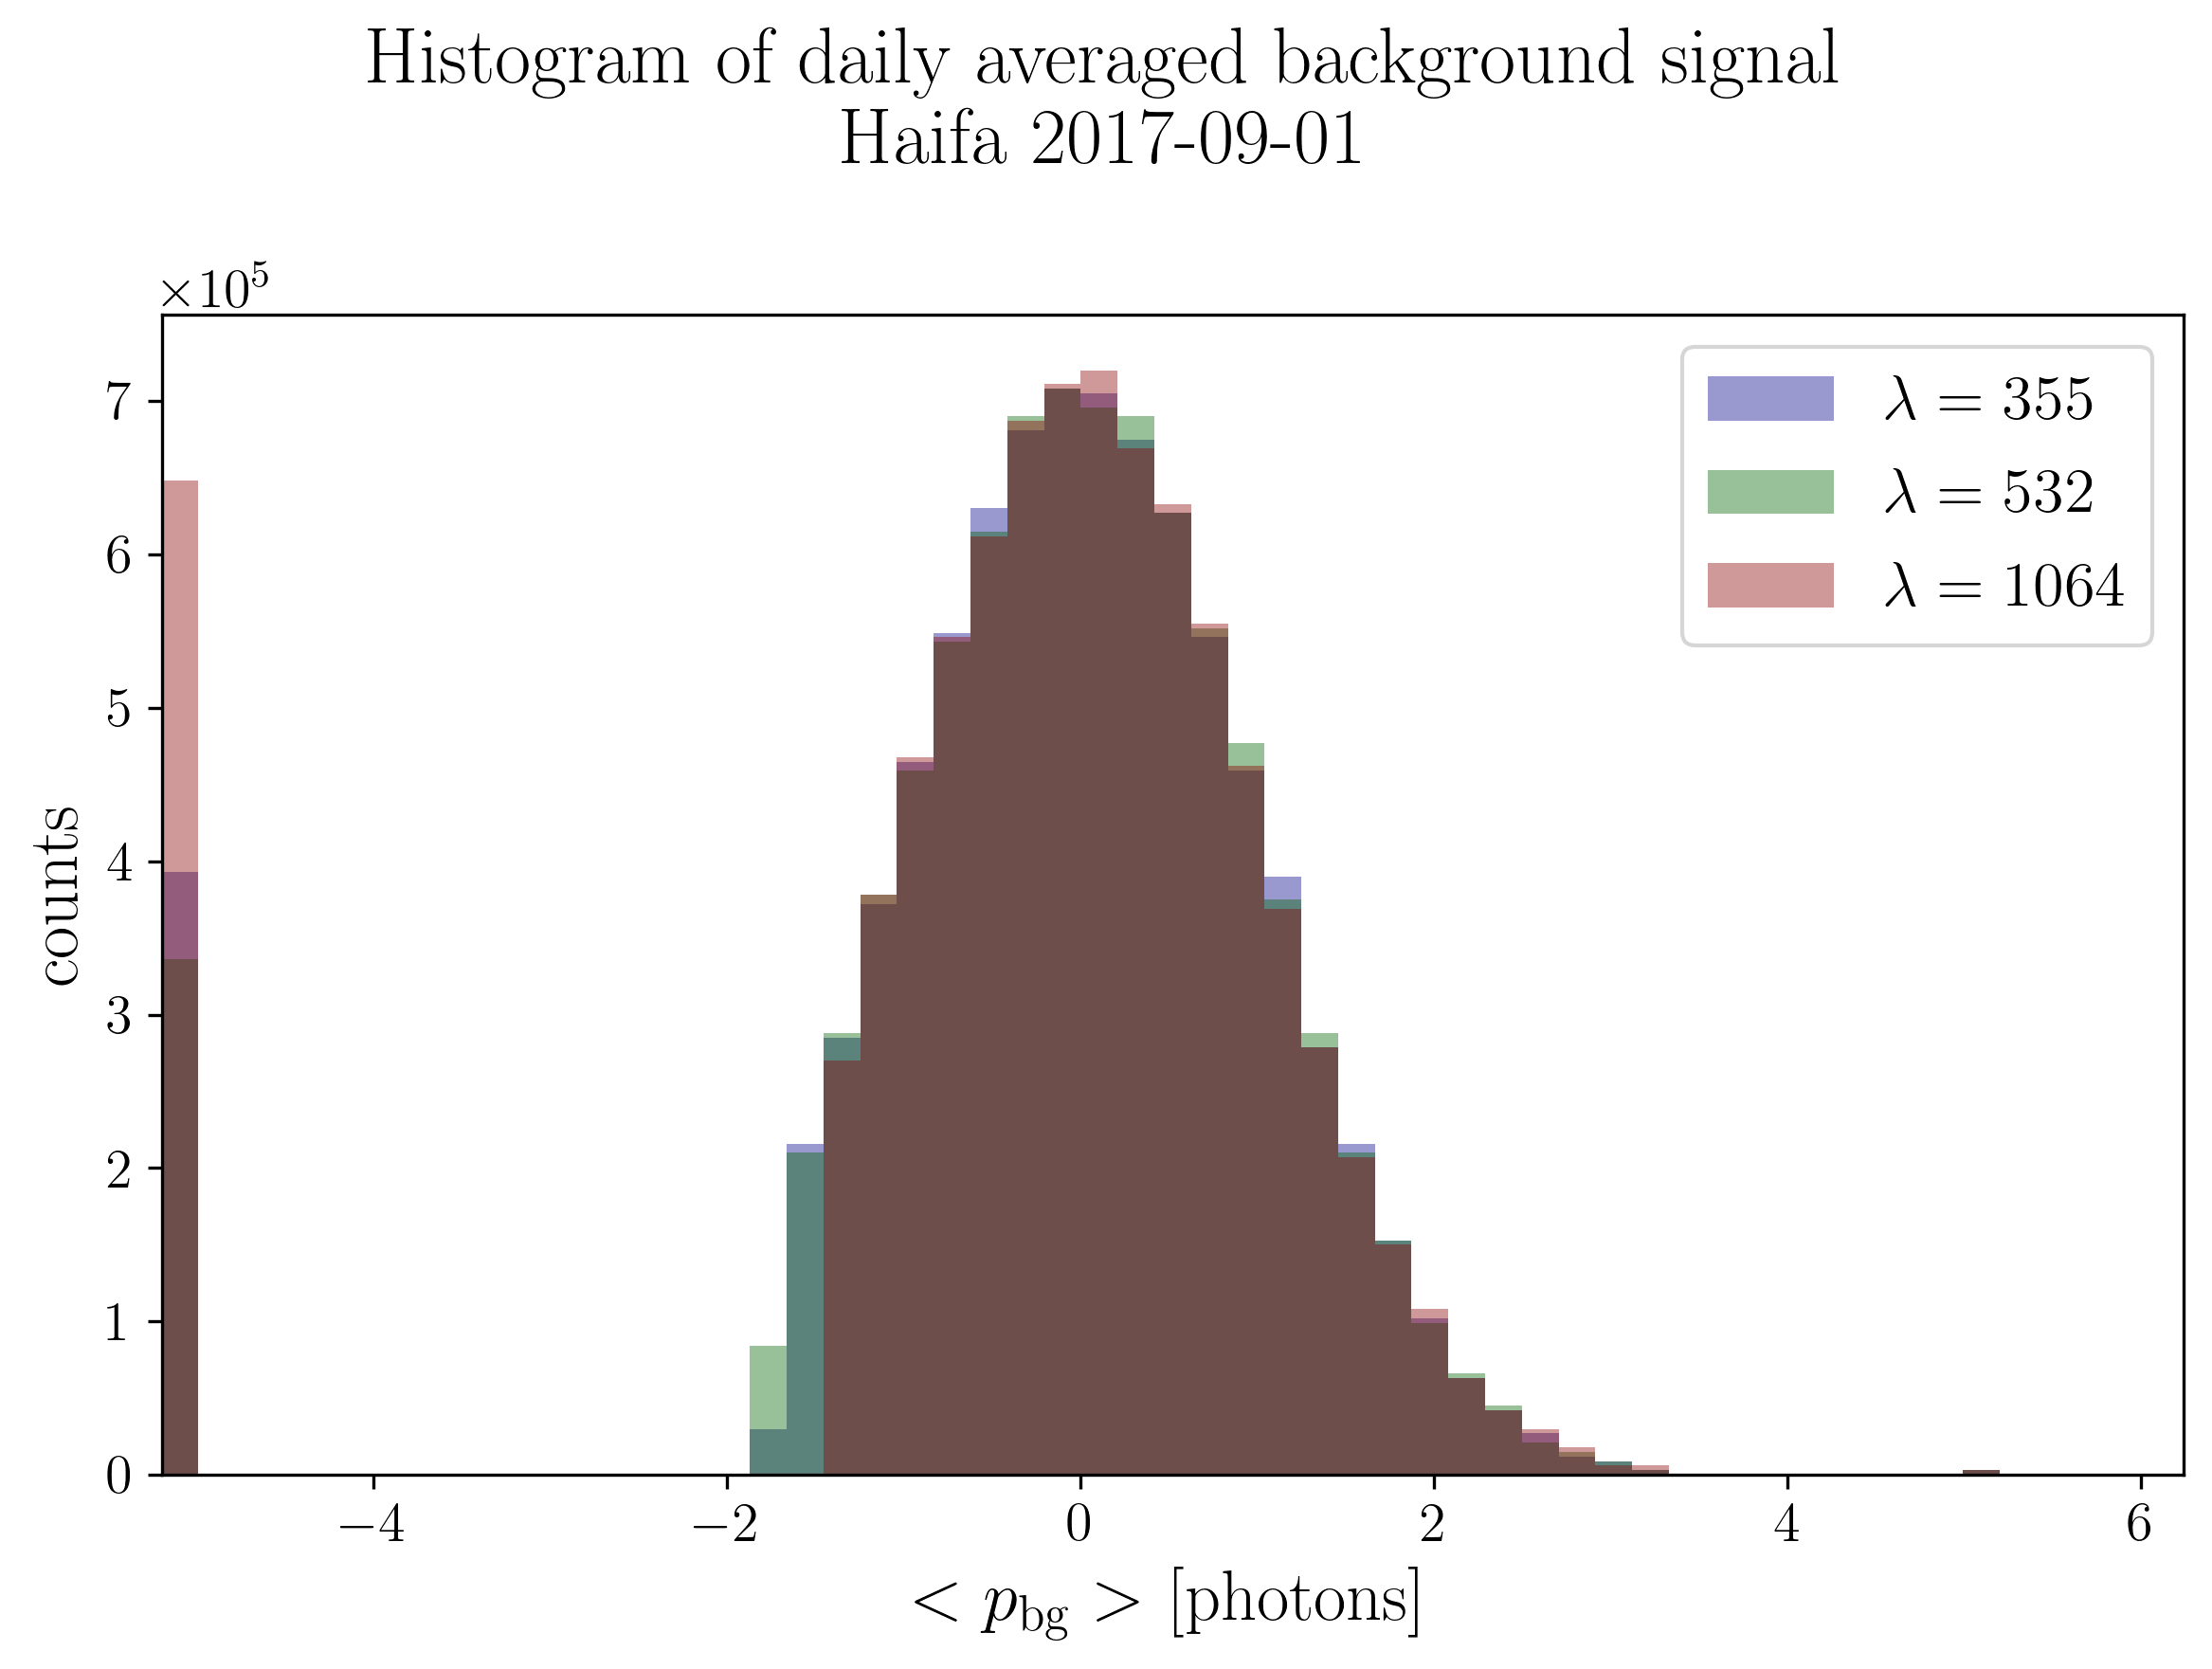

wavelength [nm]  valid size %  positive %  negative %  zeros %         mean  \
0             355         100.0   49.895833   50.104167      0.0    -0.142597   
1             532         100.0   50.104167   49.895833      0.0  -0.11620222   
2            1064         100.0   50.000000   50.000000      0.0  -0.24791268   

         std  
0  1.4172659  
1  1.3620632  
2  1.6418881

In [58]:
bg_quant_data = QuantileTransformer(output_distribution='normal').fit_transform(bg_ds.bg.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
bg_ds = bg_ds.assign(bg_quant = (bg_ds.bg.sizes, bg_quant_data))
bg_ds.bg_quant.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats_quant= daily_ds_histogram(bg_ds, profile_type='bg_quant',nbins=50)
bg_stats_quant


## BG Manual Power

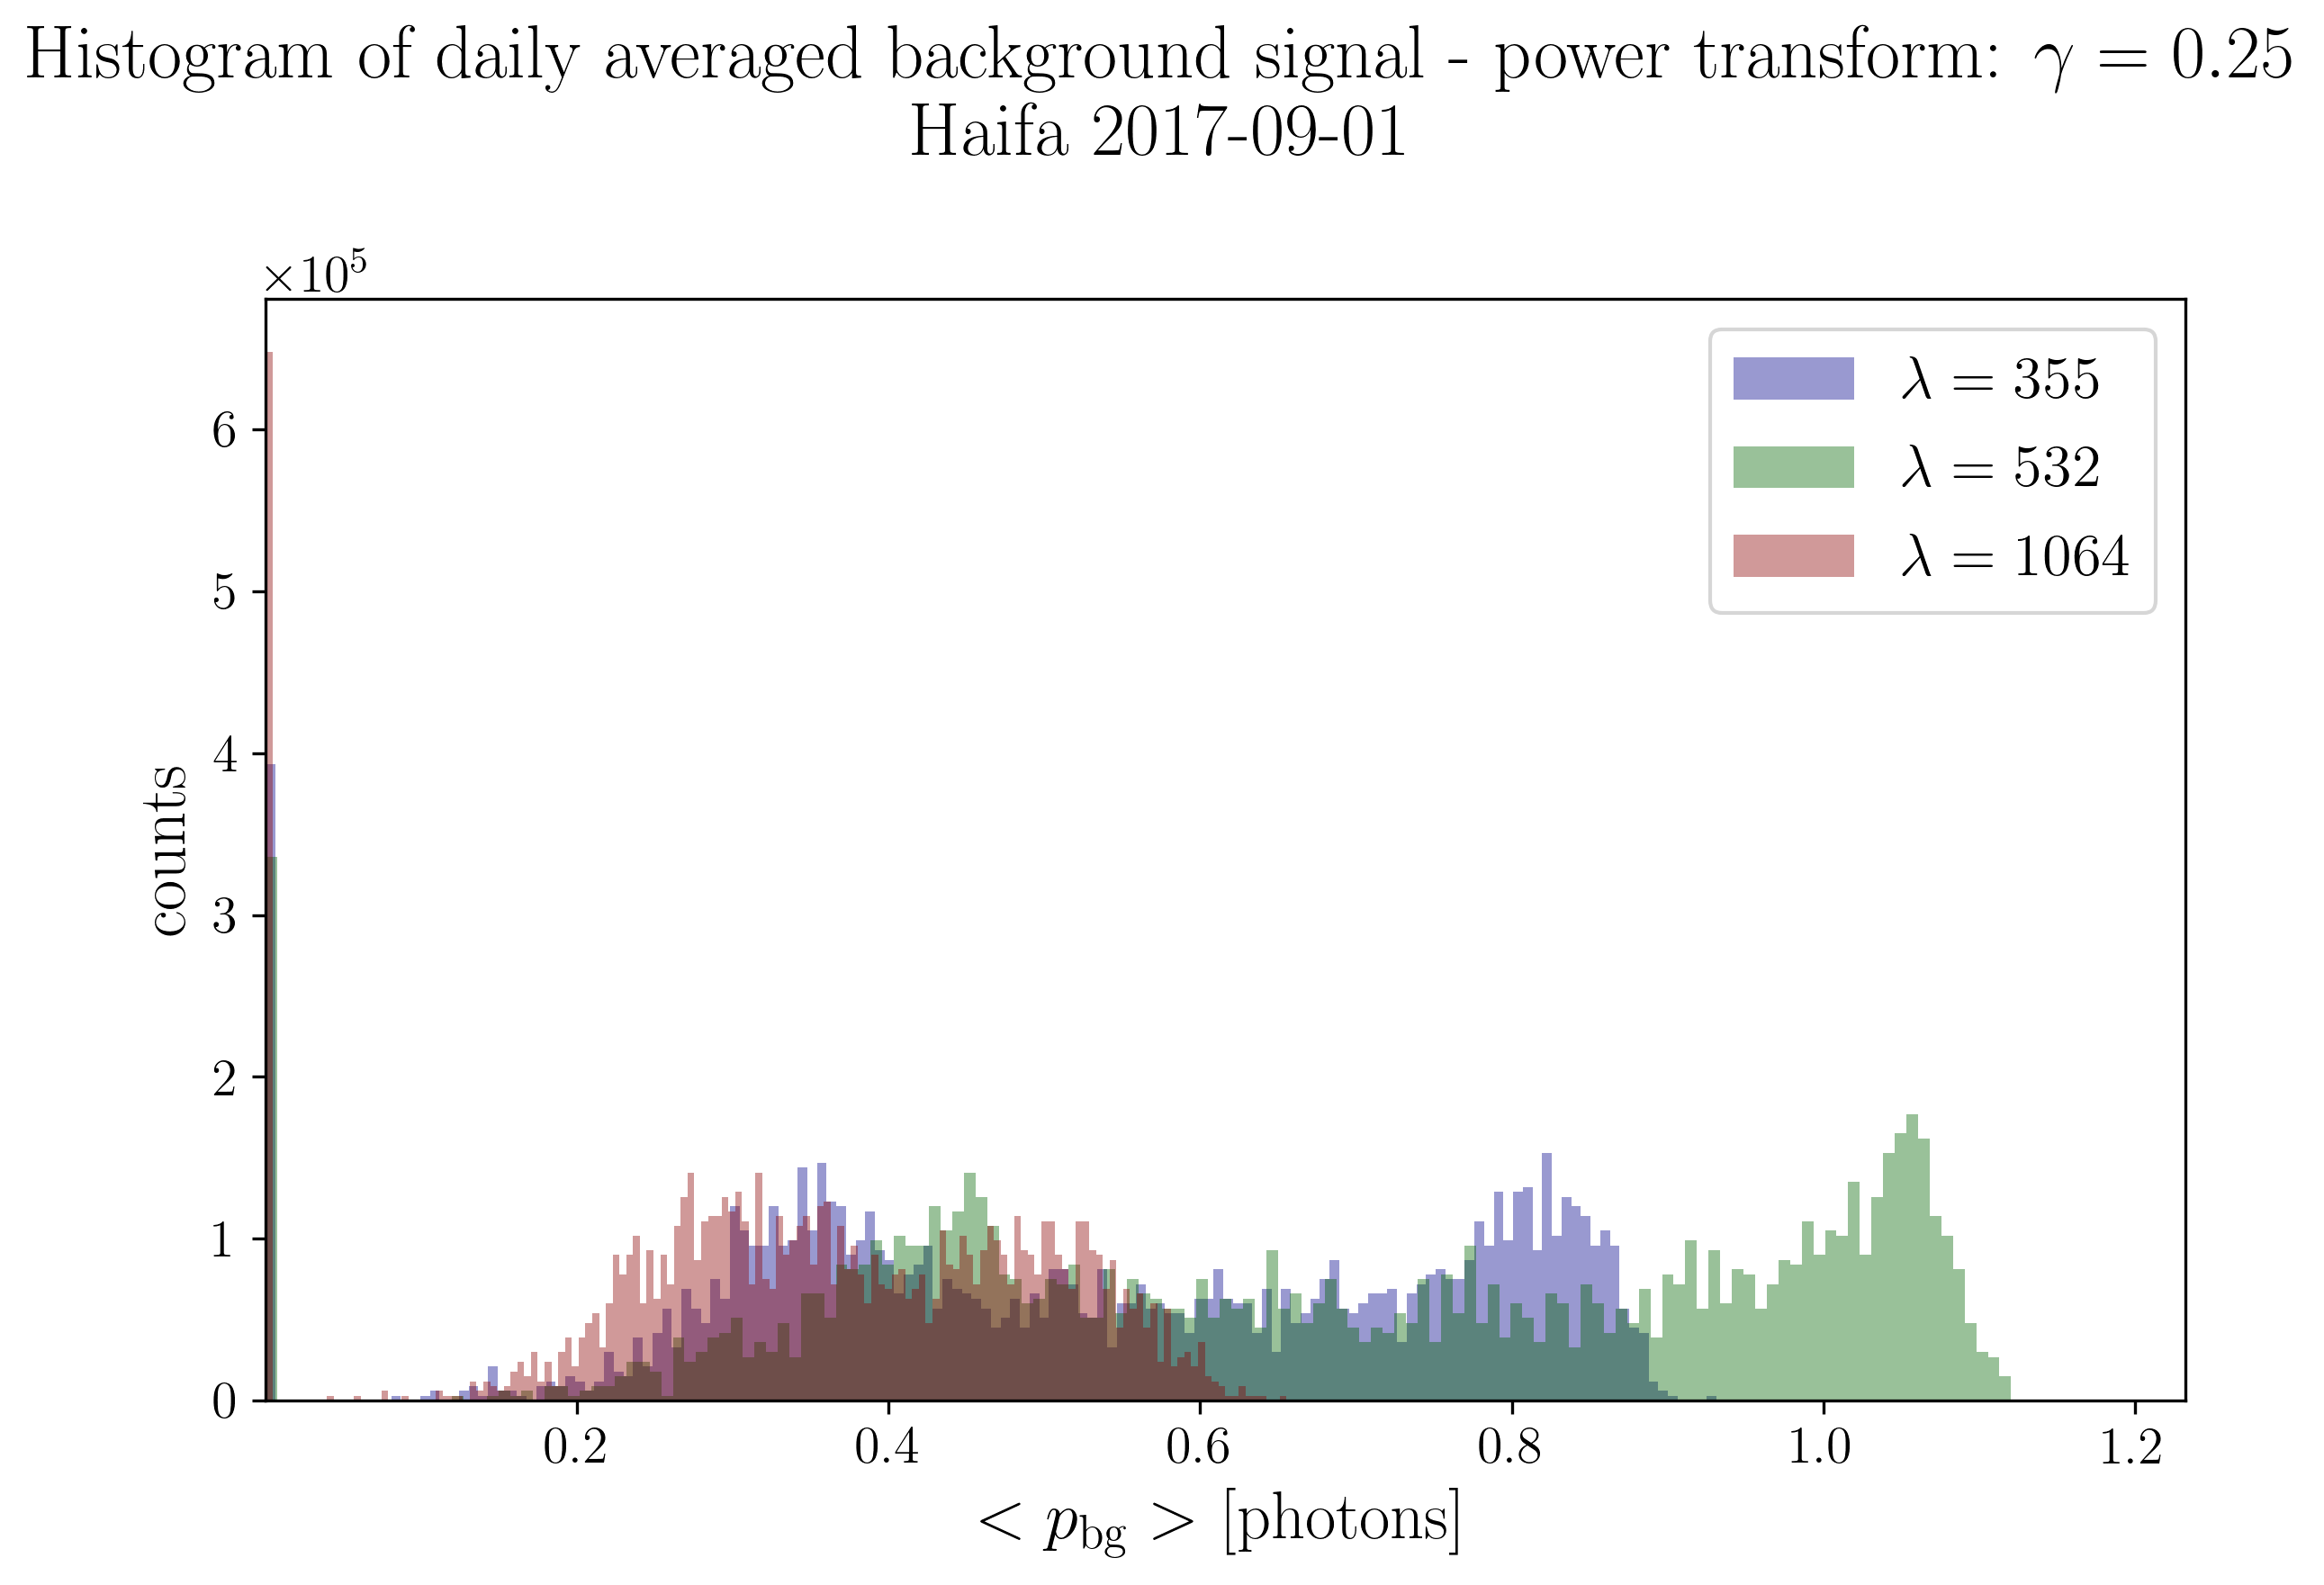

wavelength [nm]  valid size %  positive %  negative %  zeros %        mean  \
0             355         100.0       100.0         0.0      0.0   0.5349345   
1             532         100.0       100.0         0.0      0.0   0.6807669   
2            1064         100.0       100.0         0.0      0.0  0.35407704   

          std  
0   0.2303626  
1  0.28867924  
2  0.14923415

In [59]:
gamma_bg = 0.25
bg_pow = xr.apply_ufunc(lambda x: x**gamma_bg, bg_ds.bg ,keep_attrs=True)
# %%
bg_pow = bg_pow.assign_attrs({'info':bg_pow.attrs['info'] + fr' - Power transform: $\gamma={gamma_bg}$'})
bg_ds = bg_ds.assign(bg_pow= bg_pow)

# %%
_,_,bg_pow_stats= daily_ds_histogram(bg_ds, profile_type='bg_pow',nbins=150)
bg_pow_stats

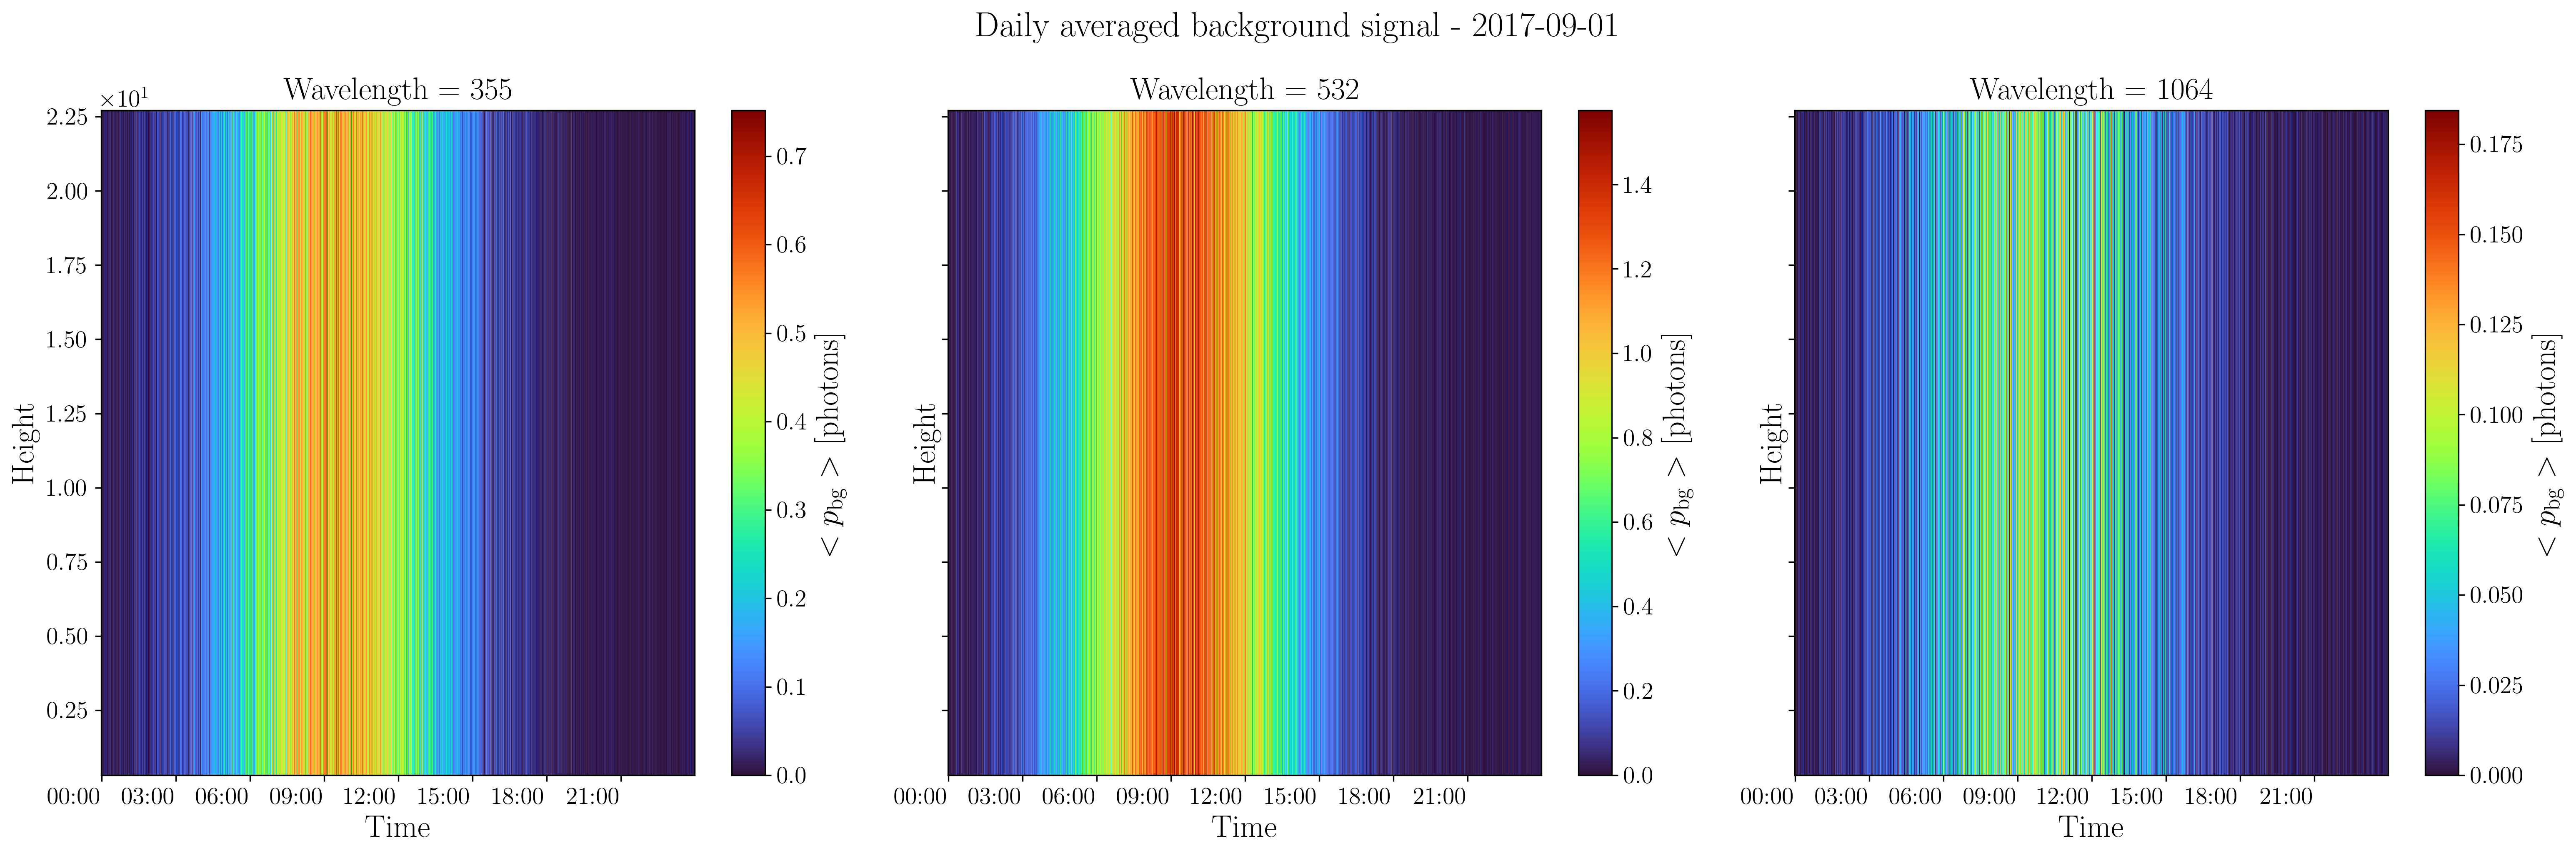

In [60]:
vis_utils.plot_daily_profile(bg_ds.bg, figsize=(21,7))

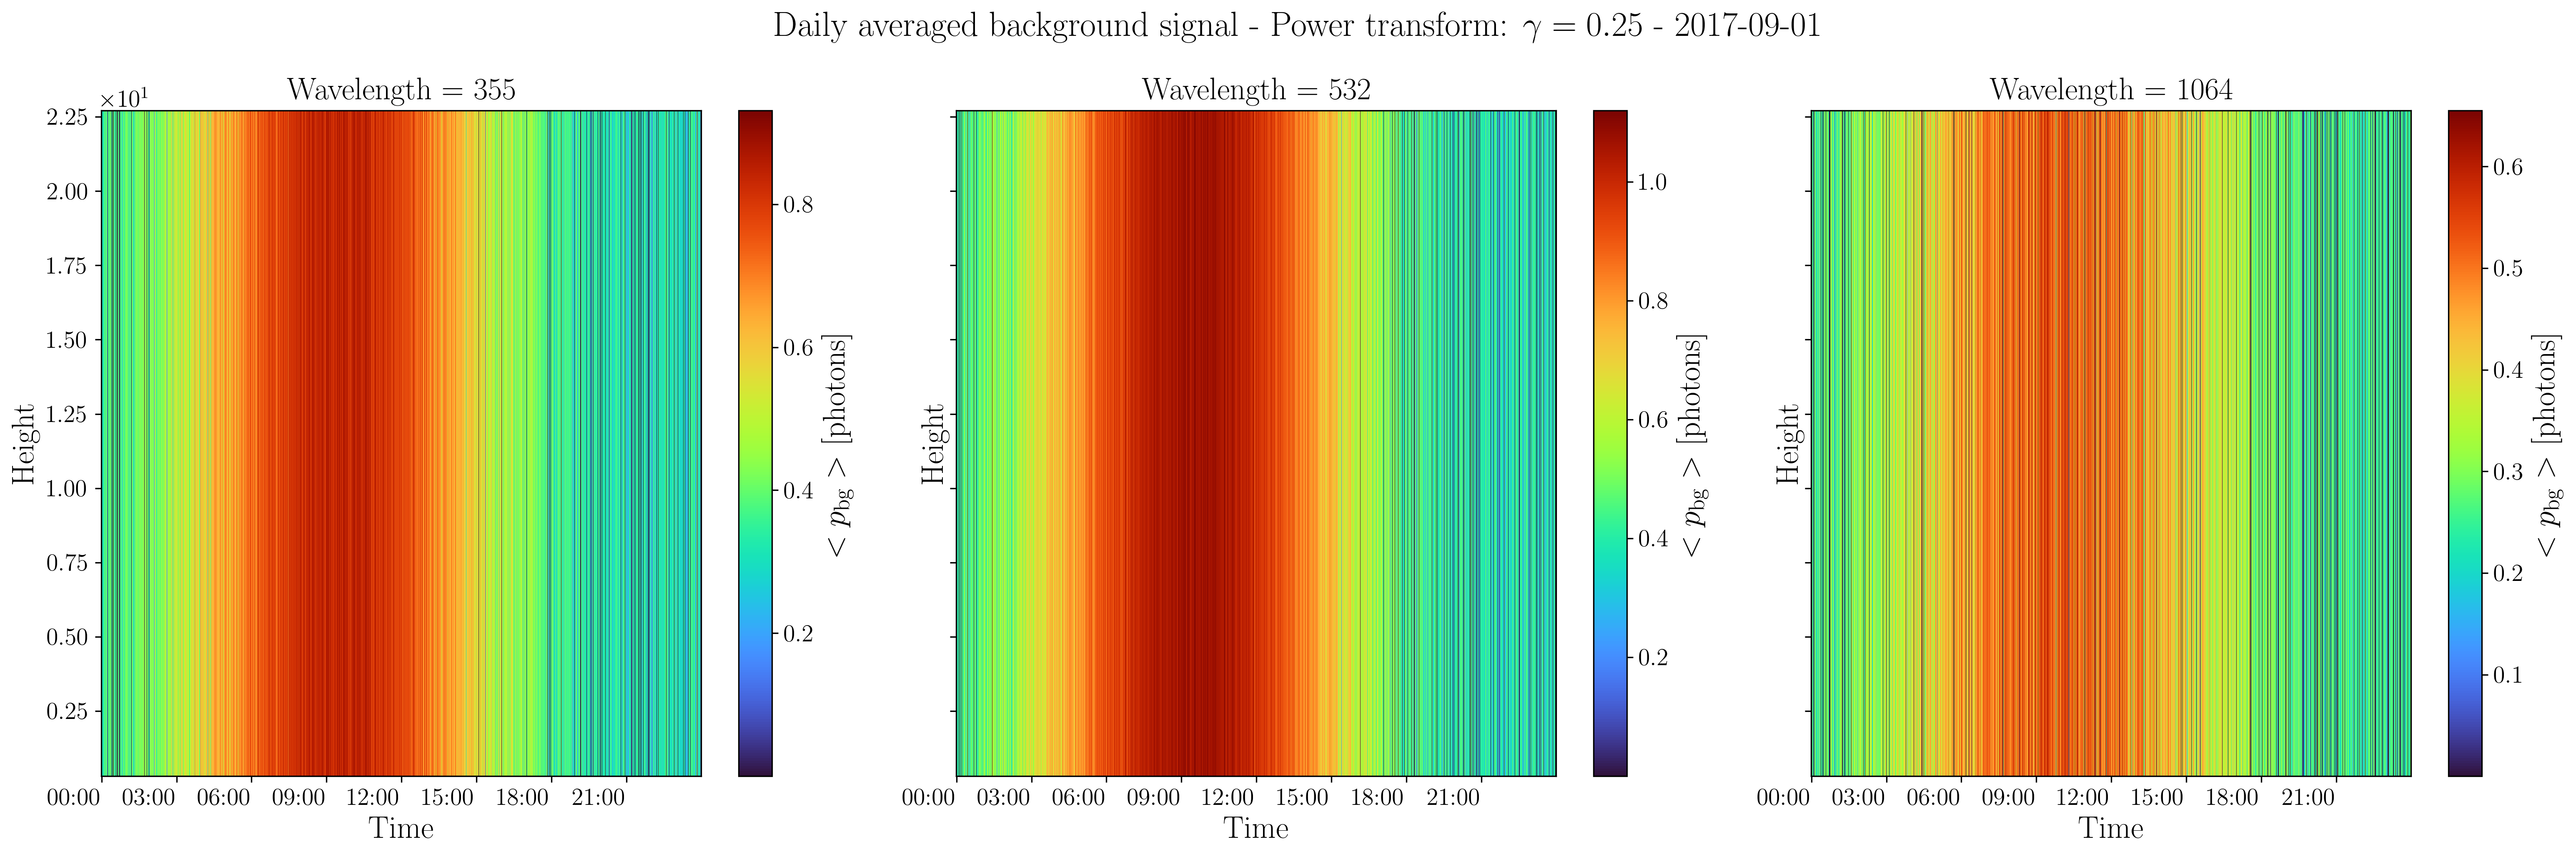

In [61]:
vis_utils.plot_daily_profile(bg_ds.bg_pow, figsize=(21,7))

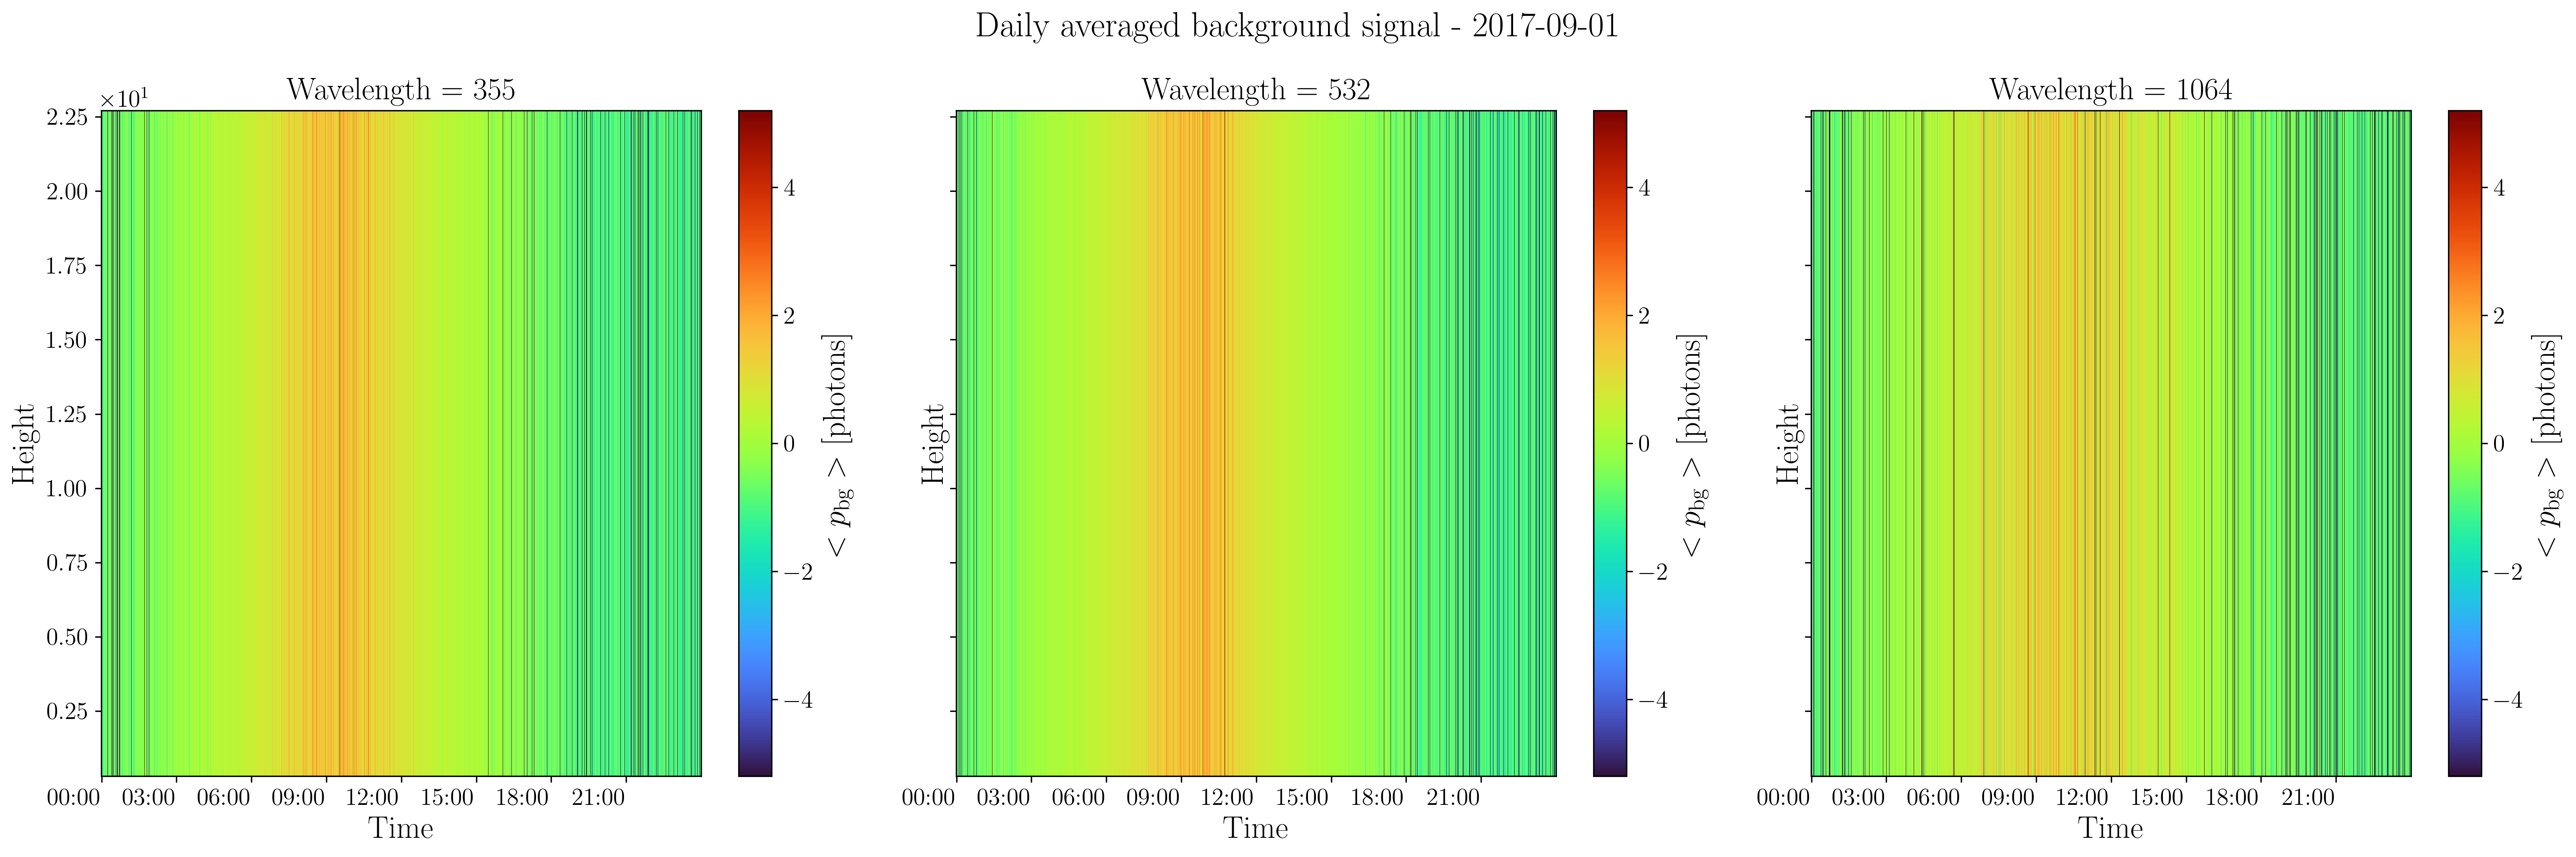

In [62]:
vis_utils.plot_daily_profile(bg_ds.bg_quant, figsize=(21,7))

# 3. Clean Lidar Signal

In [63]:
signal_folder = prep_utils.get_month_folder_name(station.gen_signal_dataset,dt_day)
signal_nc_name = os.path.join(signal_folder,
                             gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='signal'))
signal_ds = prep.load_dataset(signal_nc_name)


## BG R2

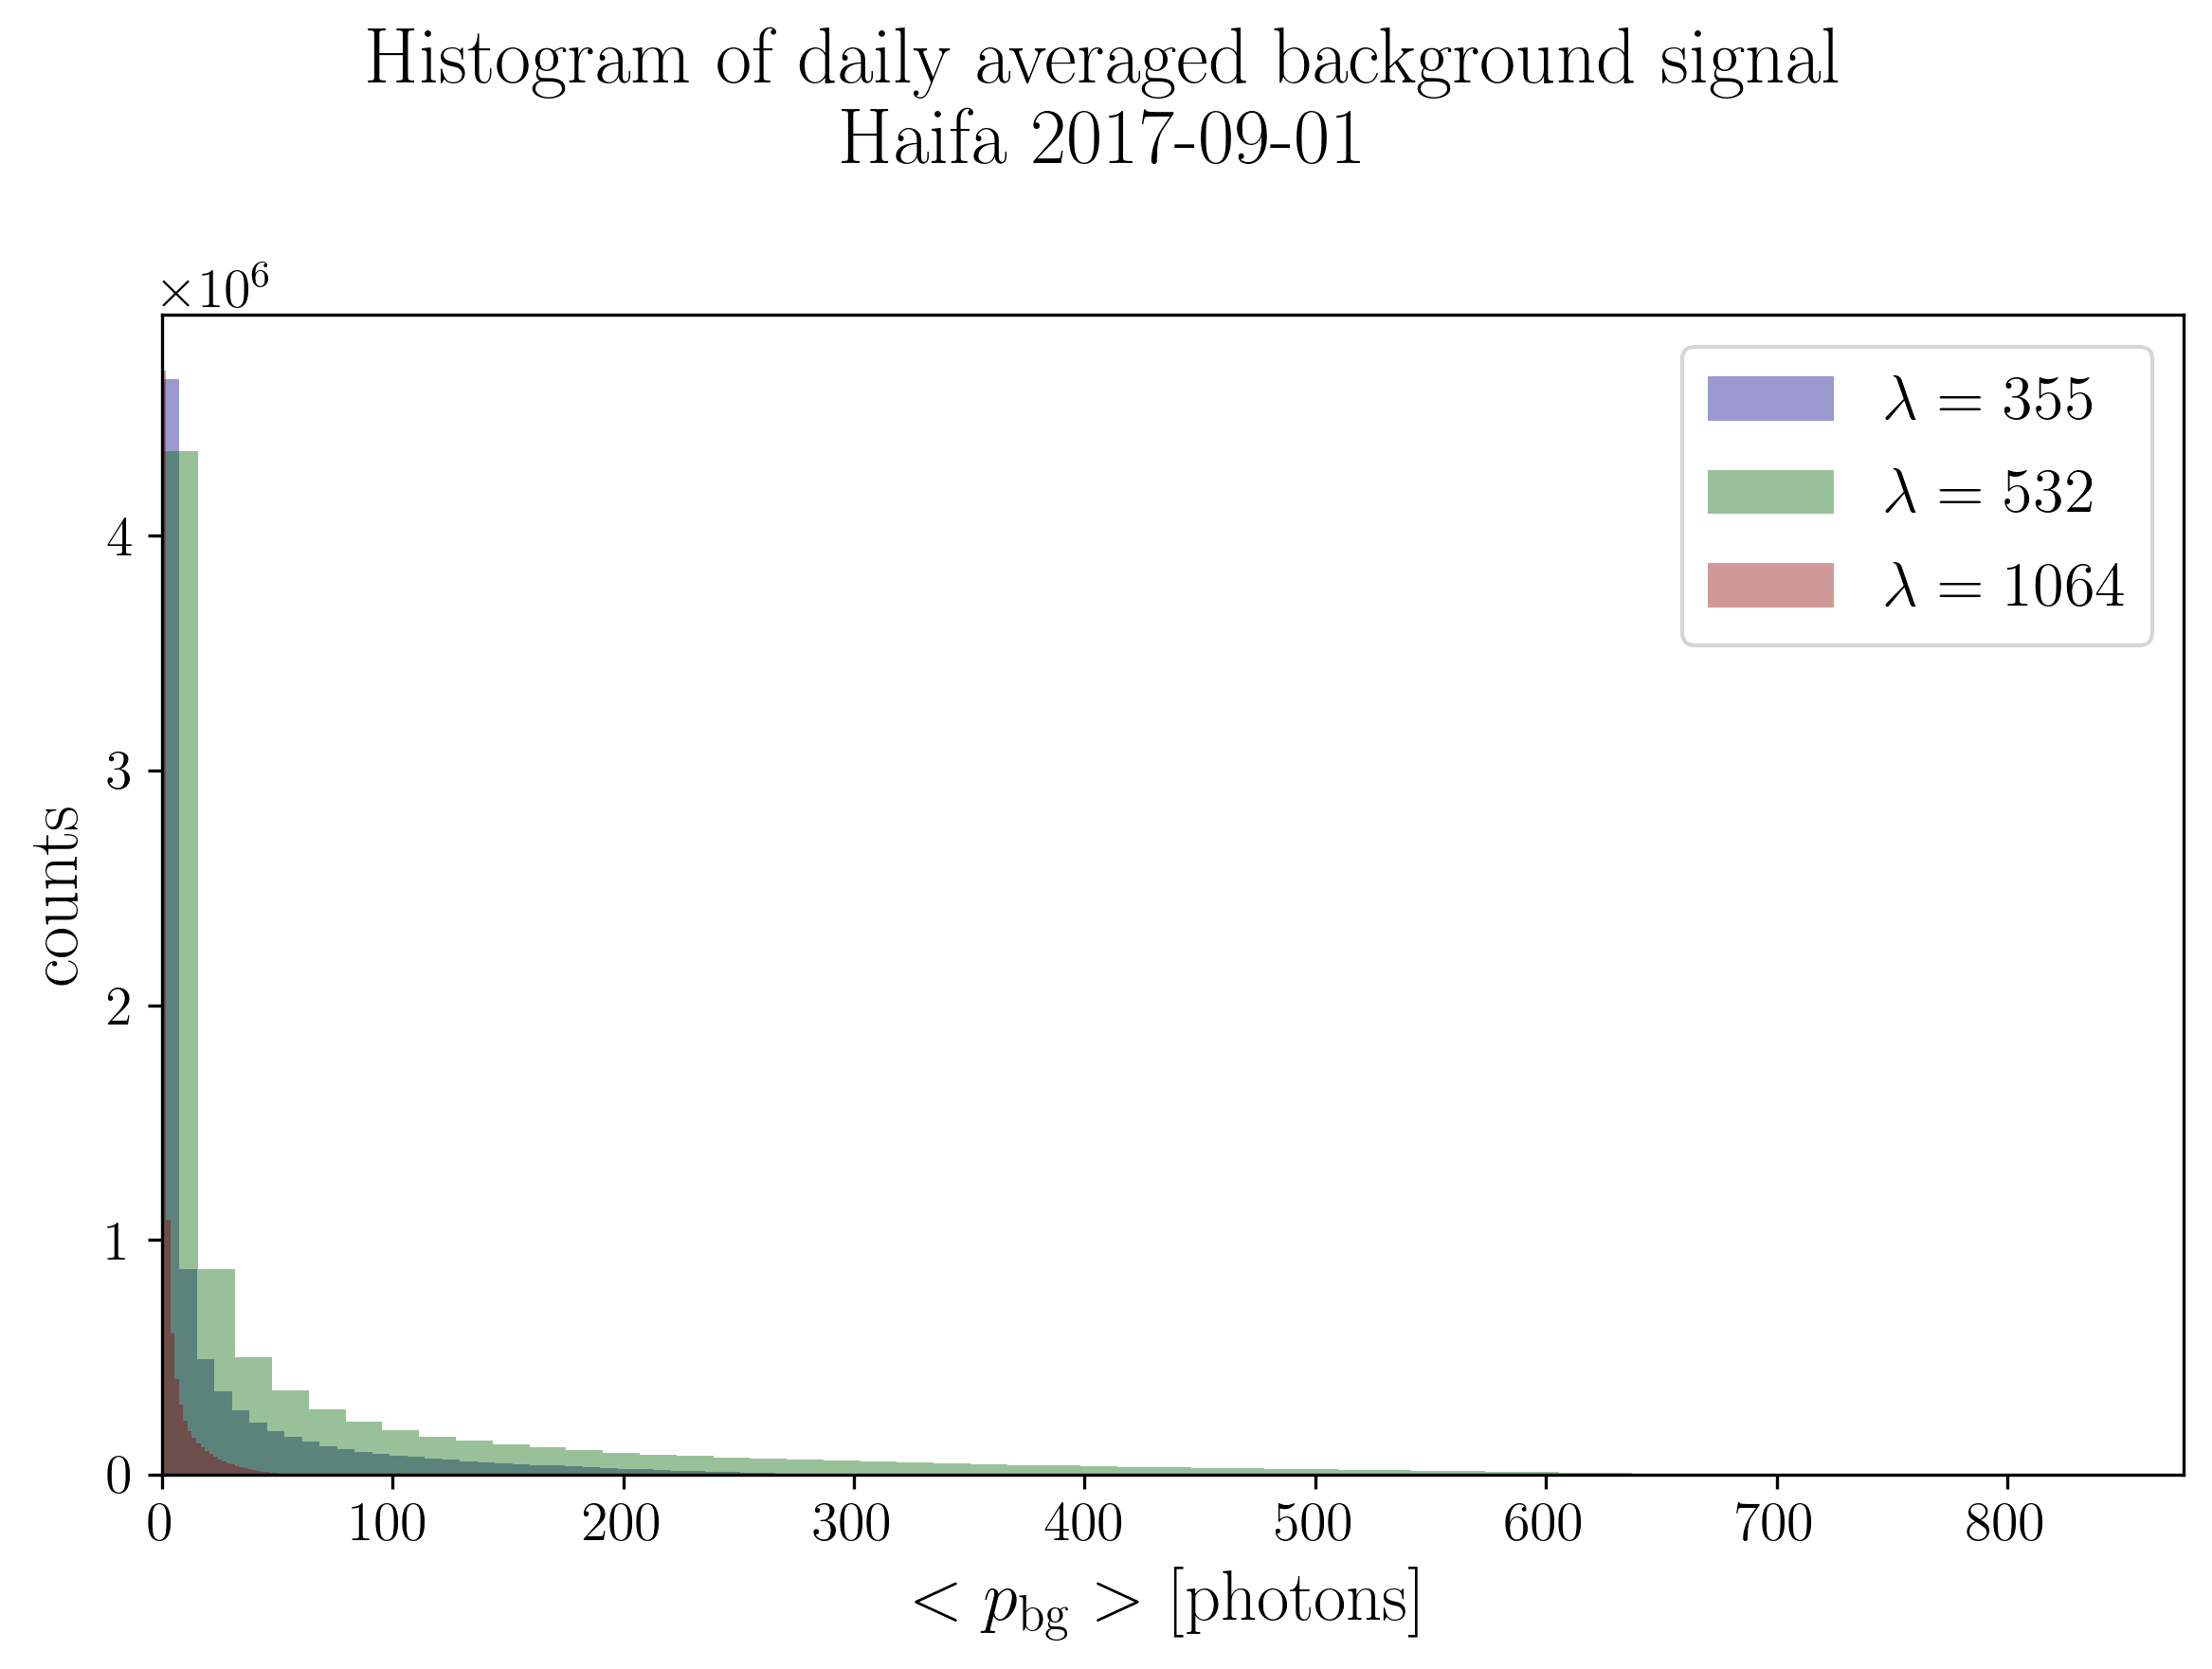

wavelength [nm]  valid size %  positive %  negative %   zeros %       mean  \
0             355         100.0   99.811991         0.0  0.188009  28.934824   
1             532         100.0   99.839259         0.0  0.160741   74.50512   
2            1064         100.0   99.690000         0.0  0.310000   5.223877   

          std  
0    49.14064  
1  124.278885  
2    8.790916

In [64]:
bg_r2 =  bg_ds.bg*signal_ds.r2
bg_ds = bg_ds.assign(bg_r2 = (bg_ds.bg.sizes, bg_r2))
bg_ds.bg_r2.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg_r2',nbins=50)
bg_stats

## BG R2 Quantile

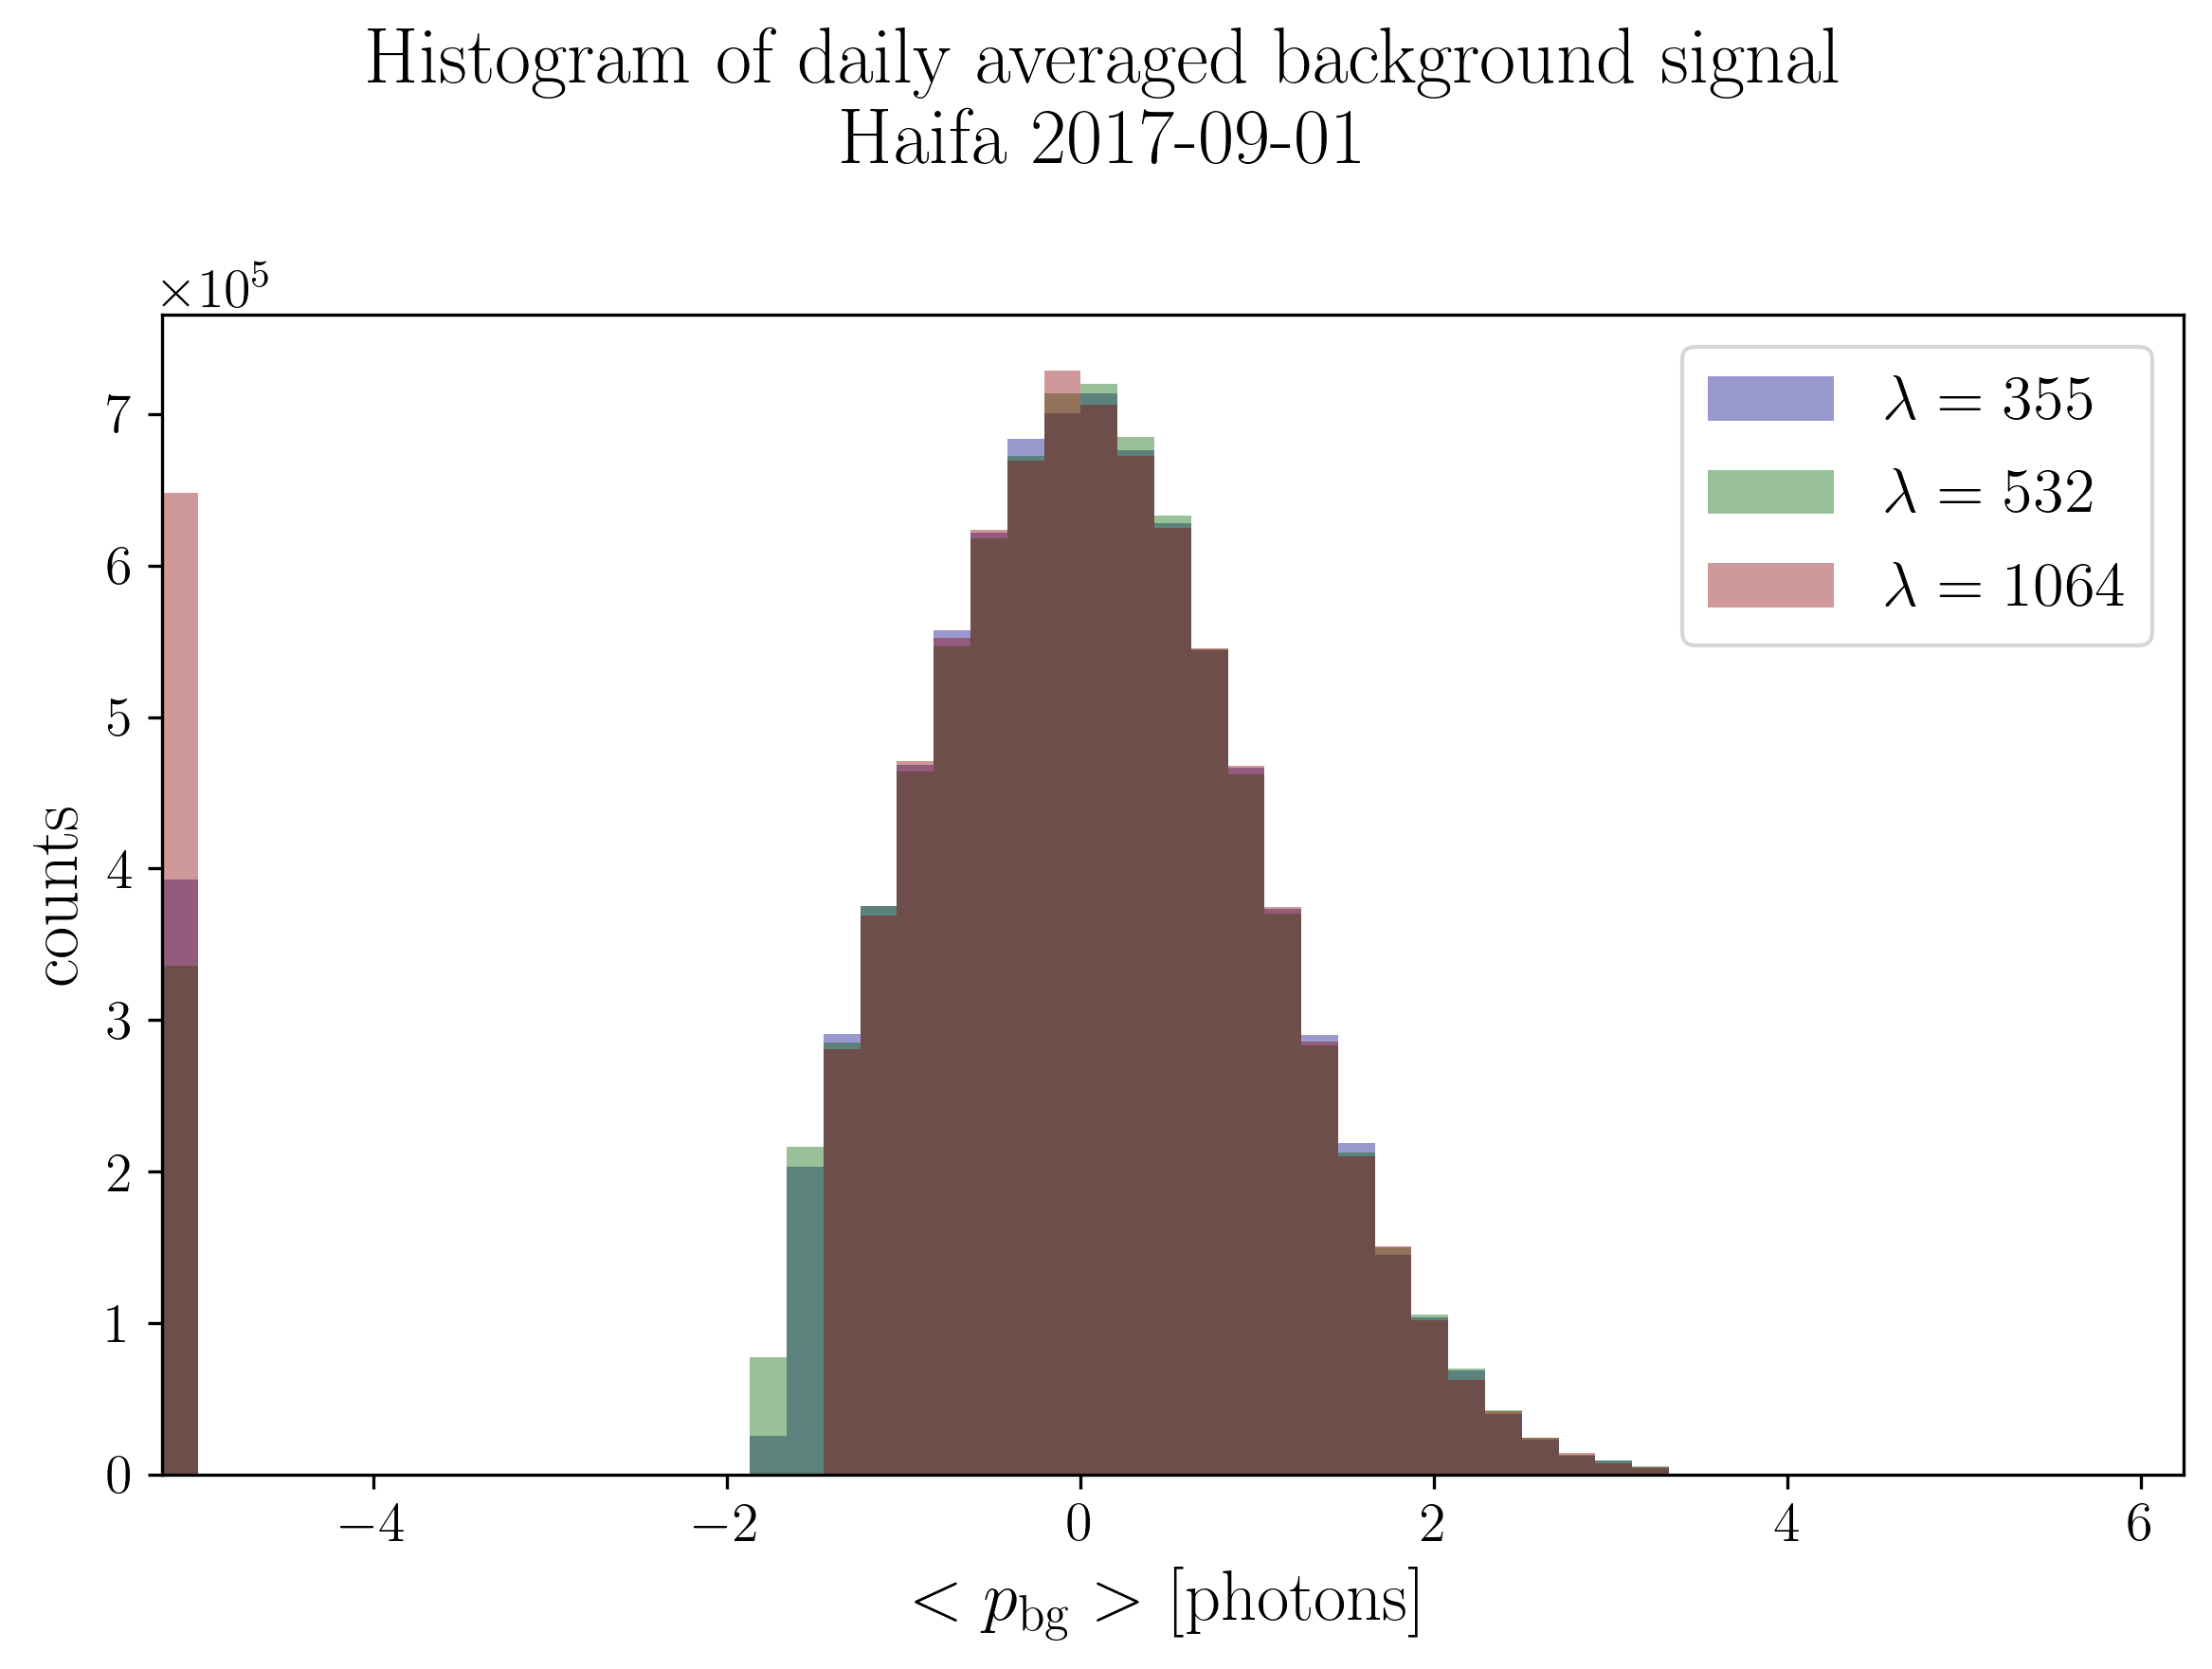

wavelength [nm]  valid size %  positive %  negative %   zeros %  \
0             355         100.0   49.997650   50.002338  0.000012   
1             532         100.0   50.170174   49.829815  0.000012   
2            1064         100.0   49.742755   50.257245  0.000000   

           mean        std  
0   -0.14241652  1.4138002  
1  -0.116202176  1.3608909  
2   -0.25334057  1.6377112

In [65]:
pt = QuantileTransformer(output_distribution='normal')
bg_r2_quant_data = pt.fit_transform(bg_r2.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
bg_ds = bg_ds.assign(bg_r2_quant = (bg_ds.bg.sizes, bg_r2_quant_data))
bg_ds.bg_r2_quant.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg_r2_quant',nbins=50)
bg_stats

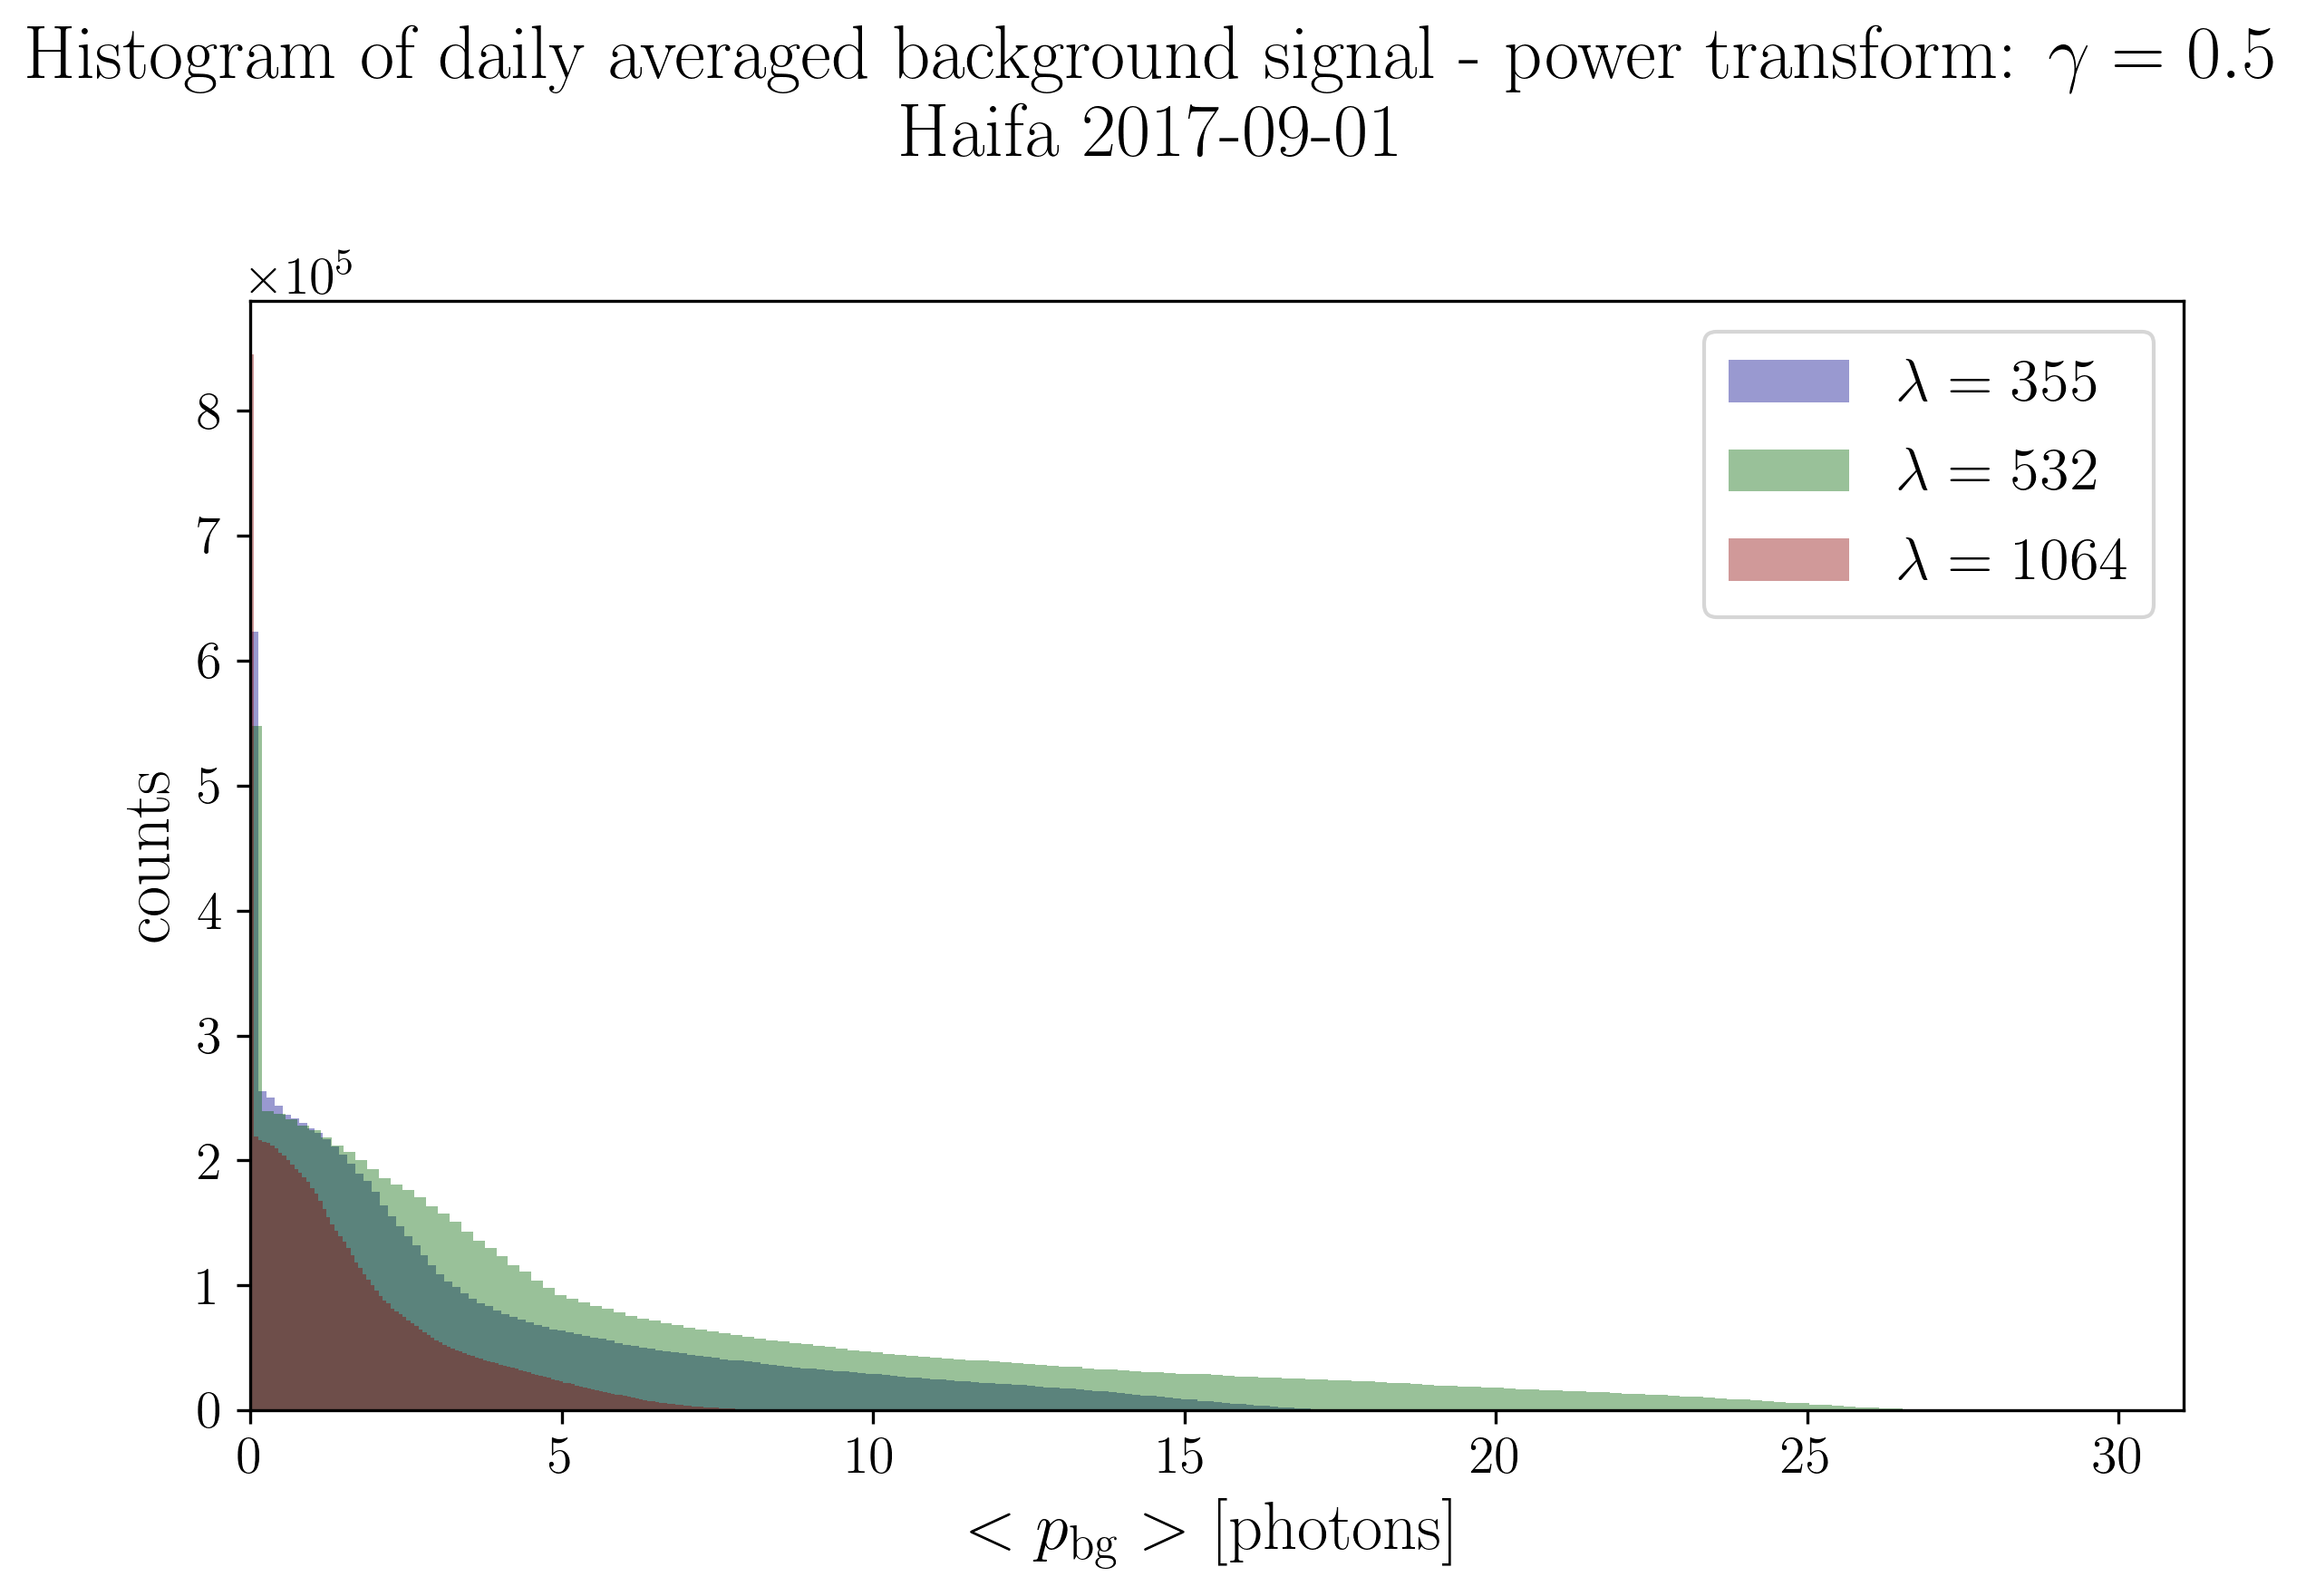

wavelength [nm]  valid size %  positive %  negative %  zeros %       mean  \
0             355         100.0       100.0         0.0      0.0  3.8271675   
1             532         100.0       100.0         0.0      0.0  6.1688695   
2            1064         100.0       100.0         0.0      0.0   1.665717   

         std  
0  3.7798965  
1  6.0373964  
2   1.565013

In [66]:
gamma_bgr2 = 0.5
bgr2n_pow = xr.apply_ufunc(lambda x: x**gamma_bgr2, bg_ds.bg_r2 ,keep_attrs=True)
# %%
bgr2n_pow = bgr2n_pow.assign_attrs({'info':bgr2n_pow.attrs['info'] +
                                         fr' - Power transform: $\gamma={gamma_bgr2}$'})
bg_ds = bg_ds.assign(bgr2pow= bgr2n_pow)

# %%
_,_,bgr2_pow_stats= daily_ds_histogram(bg_ds, profile_type='bgr2pow',nbins=150)
bgr2_pow_stats

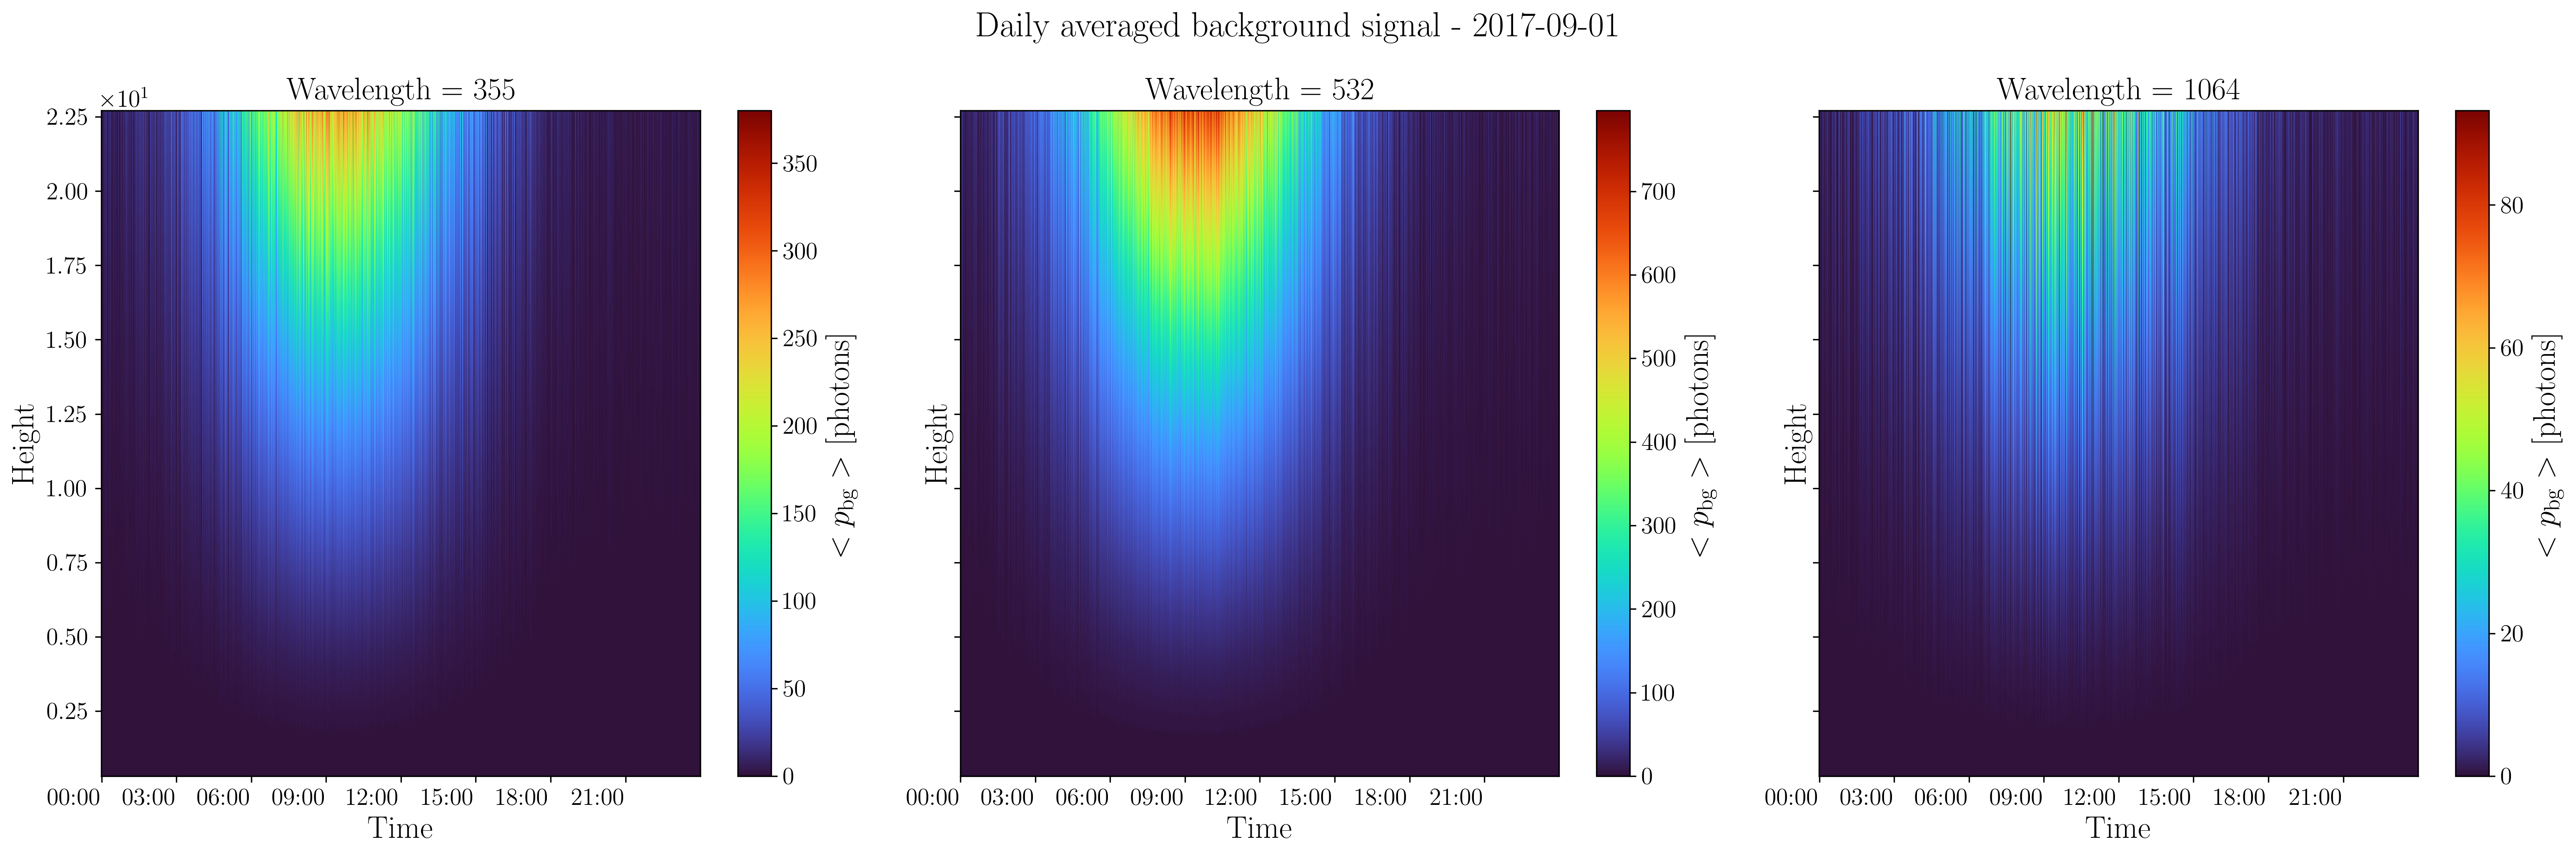

In [67]:
vis_utils.plot_daily_profile(bg_ds.bg_r2, figsize=(21,7))

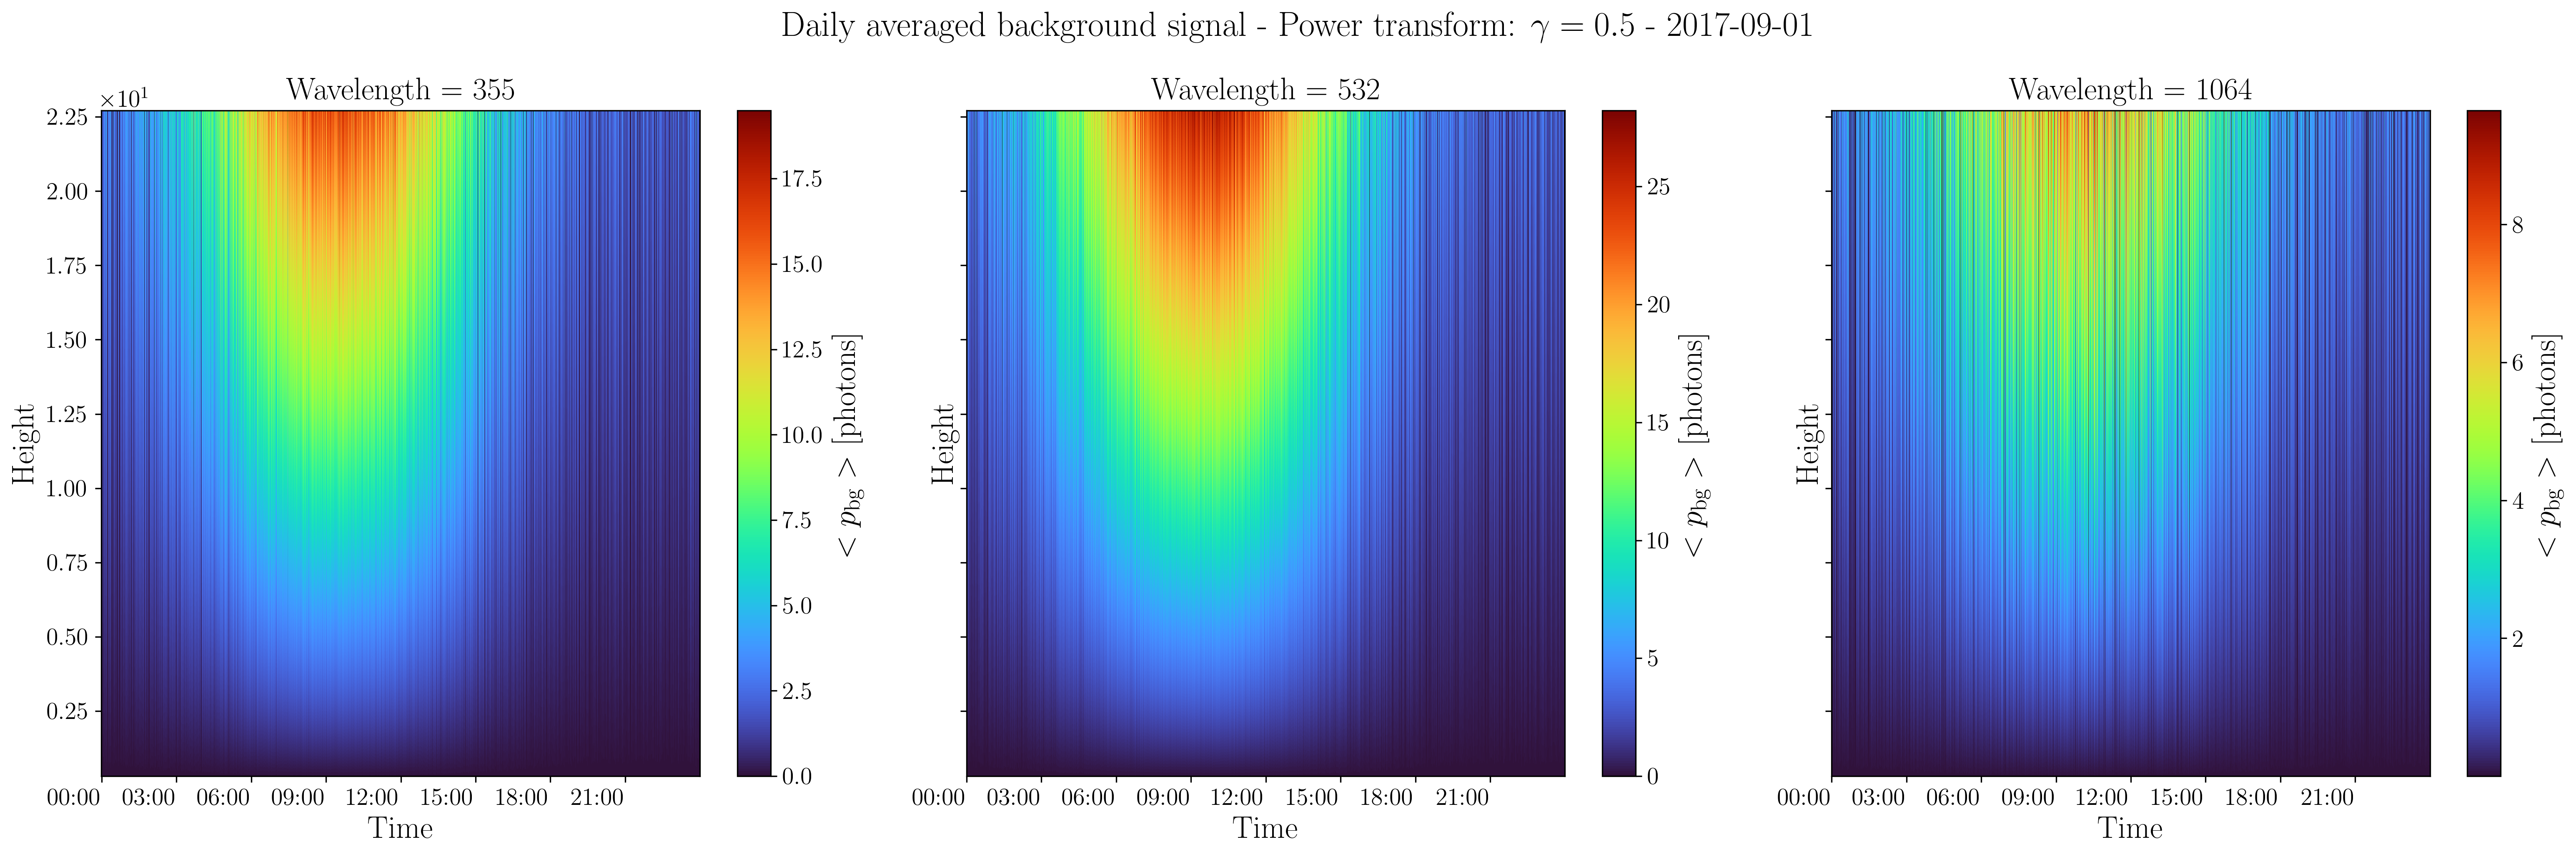

In [68]:
vis_utils.plot_daily_profile(bg_ds.bgr2pow, figsize=(21,7))

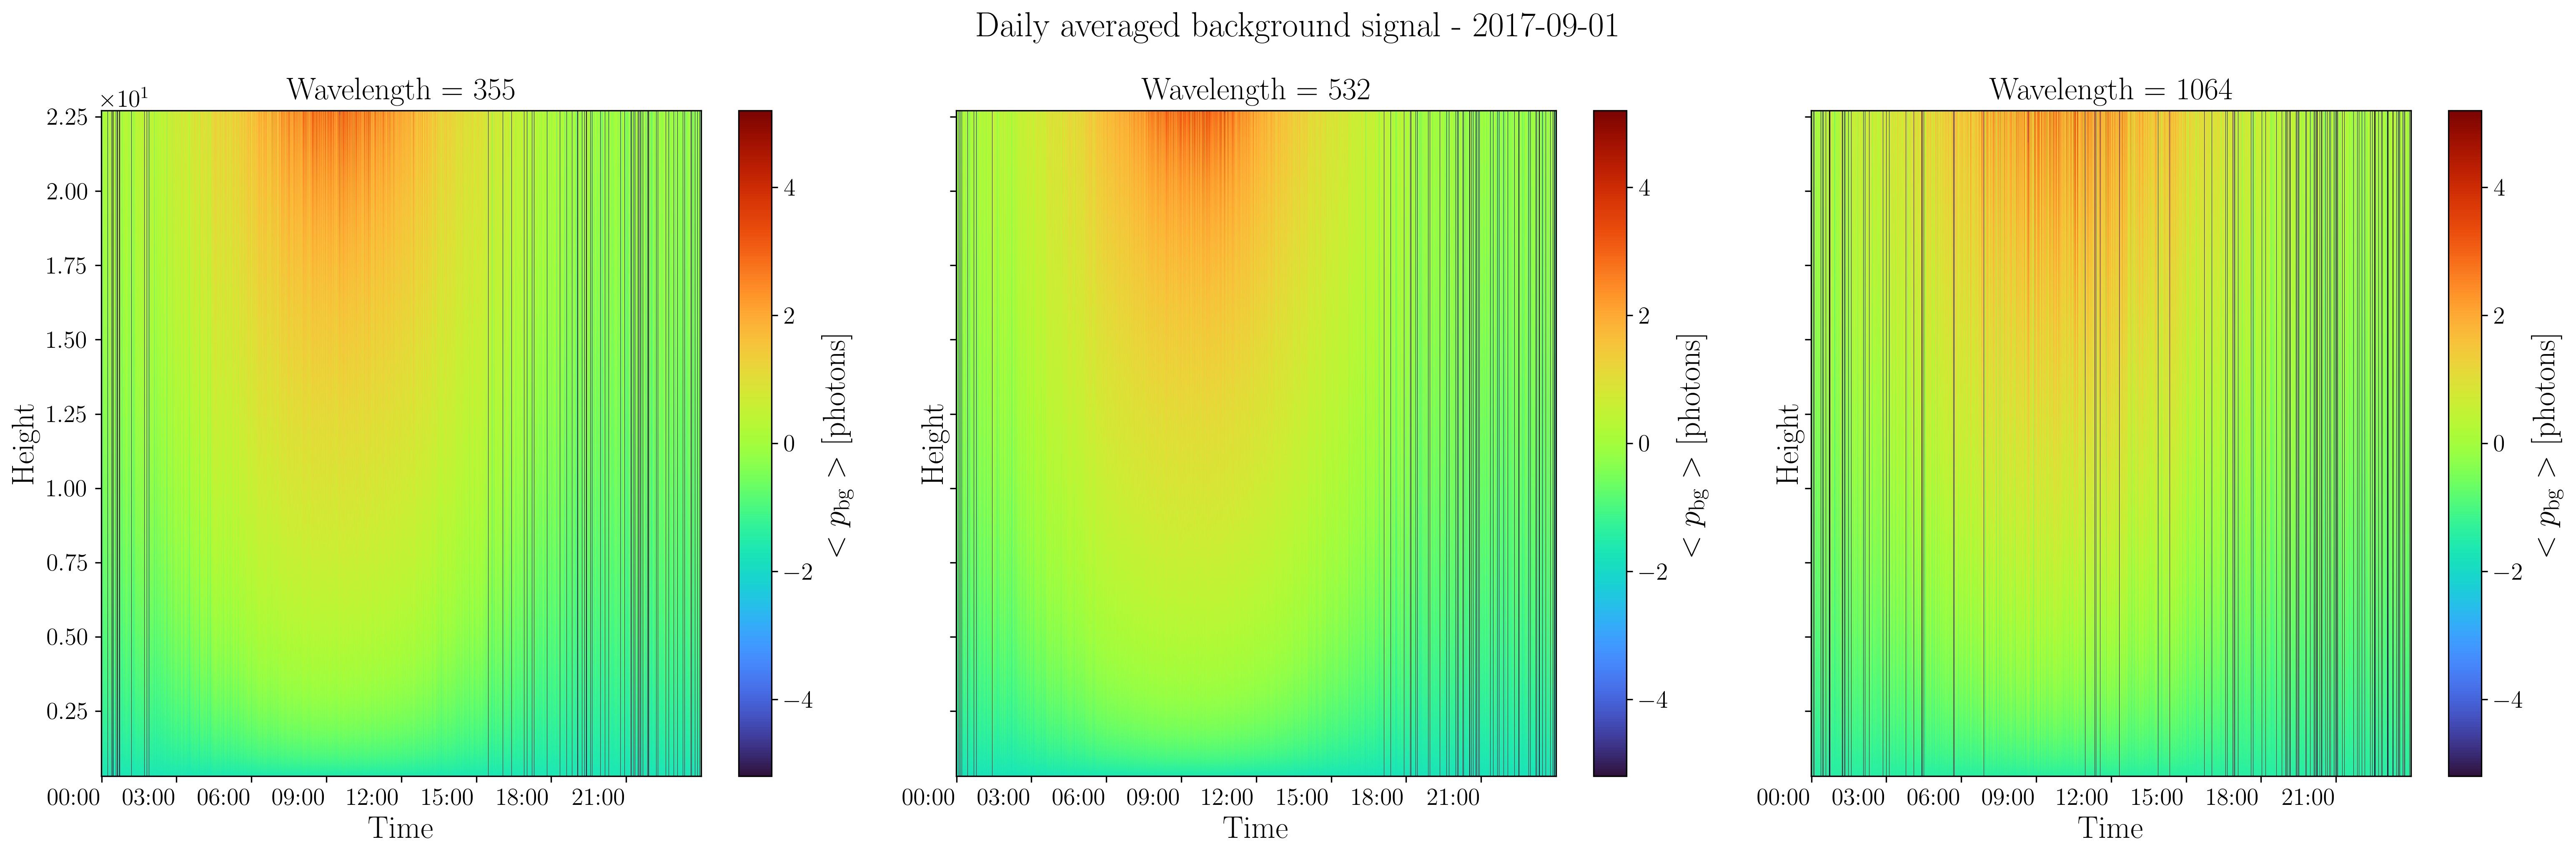

In [69]:
vis_utils.plot_daily_profile(bg_ds.bg_r2_quant, figsize=(21,7))

# 4. Lidar measurement
## TODO: test transformers on lidar_ds.p



In [70]:
lidar_folder = prep_utils.get_month_folder_name(station.gen_lidar_dataset,dt_day)
lidar_nc_name = os.path.join(lidar_folder,gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='lidar'))
lidar_ds = prep_utils.load_dataset(lidar_nc_name)

AttributeError: module 'learning_lidar.preprocessing.preprocessing_utils' has no attribute 'load_dataset'

# 6. Lidar range corrected measurement
# TODO: test transformers on lidar_ds.range_corr


## Lidar Rangecorr

In [ ]:
_,_,pr2n_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr',nbins=100)#,log_scale=True)
pr2n_stats

## Lidar Rangecorr Power Manual

In [ ]:
gamma_pr2 = 0.5
pr2n_pow = xr.apply_ufunc(lambda x: x**gamma_pr2, lidar_ds.range_corr ,keep_attrs=True)
# %%
pr2n_pow = pr2n_pow.assign_attrs({'info':pr2n_pow.attrs['info'] +
                                         fr' - Power transform: $\gamma={gamma_pr2}$'})
lidar_ds = lidar_ds.assign(pr2pow= pr2n_pow)

# %%
_,_,pr2_pow_stats= daily_ds_histogram(lidar_ds, profile_type='pr2pow',nbins=150)
pr2_pow_stats

## Lidar Rangecorr Quantile

In [ ]:
pt = QuantileTransformer(output_distribution='normal')
lidar_range_corr_quant_data = pt.fit_transform(lidar_ds.range_corr.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
lidar_ds = lidar_ds.assign(range_corr_quant = (lidar_ds.range_corr.sizes, lidar_range_corr_quant_data))
lidar_ds.range_corr_quant.attrs.update(lidar_ds.range_corr.attrs)
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr_quant',nbins=150)#,log_scale=True)
lidar_stats

In [ ]:
vis_utils.plot_daily_profile(lidar_ds.range_corr, figsize=(21,7))

In [ ]:
vis_utils.plot_daily_profile(lidar_ds.pr2pow, figsize=(21,7))


In [ ]:
vis_utils.plot_daily_profile(lidar_ds.range_corr_quant, figsize=(21,7))

# 7. Molecular signal (attenuated backscatter)
# TODO: test transformers on mol_ds.attbsc

In [ ]:
mol_folder = prep_utils.get_month_folder_name(station.molecular_dataset,dt_day)
mol_nc_name = os.path.join(mol_folder, prep_utils.get_prep_dataset_file_name(station,dt_day,data_source='molecular',lambda_nm='all'))
mol_ds = prep_utils.load_dataset(mol_nc_name)

## Molecular

In [ ]:
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc',nbins=100)#,log_scale=True)
mol_stats

## Molecular Power Manual

In [ ]:
gamma_mol = 0.2
mol_attbsc_pow = xr.apply_ufunc(lambda x: x**gamma_mol, mol_ds.attbsc ,keep_attrs=True)
# %%
mol_attbsc_pow = mol_attbsc_pow.assign_attrs({'info':mol_attbsc_pow.attrs['info'] +
                                                     fr' - Power transform: $\gamma={gamma_mol}$'})
mol_ds = mol_ds.assign(attbscpow= mol_attbsc_pow)

# %%
_,_,molattbsc_pow_stats= daily_ds_histogram(mol_ds, profile_type='attbscpow',nbins=150)
molattbsc_pow_stats

## Molecular Quantile

In [ ]:
pt = QuantileTransformer(output_distribution='normal')
mol_attbsc_quant_data = pt.fit_transform(mol_ds.attbsc.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
mol_ds = mol_ds.assign(attbsc_quant = (mol_ds.attbsc.sizes, mol_attbsc_quant_data))
mol_ds.attbsc_quant.attrs.update(mol_ds.attbsc.attrs)
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc_quant',nbins=150)#,log_scale=True)
mol_stats


In [ ]:
vis_utils.plot_daily_profile(mol_ds.attbsc, figsize=(21,7))

In [ ]:
vis_utils.plot_daily_profile(mol_ds.attbscpow, figsize=(21,7))

In [ ]:
vis_utils.plot_daily_profile(mol_ds.attbsc_quant, figsize=(21,7))